# 0.0. Imports

In [1]:
#Import Libraries
import pandas as pd
import numpy as np
import inflection
import math
import datetime
import random
import pickle

from tabulate import tabulate

from boruta import BorutaPy

from scipy import stats as ss

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso

import xgboost as xgb

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from ydata_profiling import ProfileReport

from IPython.display import Image

import warnings
warnings.filterwarnings('ignore')

# 0.1. Functions

In [2]:
#Functions
#Adjusting float data format
pd.set_option('display.float_format', '{:.2f}'.format)
np.set_printoptions(suppress=True)

#Plot
%matplotlib inline
#%pylab inline 
plt.style.use( 'bmh' )
plt.rcParams['figure.figsize'] = [25, 12]
#plt.rcParams['font.size'] = 10  
#display( HTML( '<style>.container { width:100% !important; }</style>') )
#pd.options.display.max_columns = None
#pd.options.display.max_rows = None
#pd.set_option( 'display.expand_frame_repr', False )

#Correlation Analysis of Categorical Attributes
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency(cm)[0]
    
    chi2_corr = max(0, chi2-(k-1)*(r-1)/(n-1))
    k_corr = k-(k-1)**2/(n-1)
    r_corr = r-(r-1)**2/(n-1)


    return np.sqrt((chi2_corr/n) / (min(k_corr-1, r_corr-1)))

#Analysis of Performance
def ml_error(model_name, y, y_hat):
    mae = mean_absolute_error(y, y_hat)
    mape = mean_absolute_perc_error(y, y_hat)
    rmse = np.sqrt(mean_squared_error(y, y_hat))

    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse},
                         index=[0])

#Mean Absolute Percentage Error
def mean_absolute_perc_error(y, y_hat):
    return np.mean(np.abs((y-y_hat)/y))

#Mean Percentage Error
def mean_percentage_error(y, y_hat):
    return np.mean((y-y_hat)/y)

#Cross Validation
def cross_validation(x_training, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed(range(1, kfold+1)):
        if verbose:
            print('\nKFold: {}'.format(k))

        #Validation start and end date
        val_start_dt = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        val_end_dt = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        #Filtering dataset
        training = x_training[x_training['date'] < val_start_dt]
        validation = x_training[(x_training['date'] >= val_start_dt) & (x_training['date'] <= val_end_dt)]

        #Training and Validation Dataset

        #Training
        xtrain = training.drop(['date', 'sales'], axis=1)
        ytrain = training['sales']

        #Validation
        xval = validation.drop(['date', 'sales'], axis=1)
        yval = validation['sales']

        #Model
        m = model.fit(xtrain, ytrain)

        #Prediction
        yhat = m.predict(xval)

        #Performance
        m_result = ml_error(model_name, np.expm1(yval), np.expm1(yhat))

        #Store Performance of each KFold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame({'Model Name': model_name,
                         'MAE CV': np.round(np.mean(mae_list), 2).astype(str) +'+/-'+ np.round(np.std(mae_list), 2).astype(str),
                         'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) +'+/-'+ np.round(np.std(mape_list), 2).astype(str),
                         'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) +'+/-'+ np.round(np.std(rmse_list), 2).astype(str)}, index=[0])

#Replace NA's from dataset
def replace_na(df):

    #competition_distance: null data will be 150000 (double of max distance on the dataset)
    df['competition_distance'] = df['competition_distance'].apply(lambda x: 150000 if math.isnan(x) else x)

    #competition_open_since_month: null data will be the same month of the date on the dataset
    df['competition_open_since_month'] = df.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

    #competition_open_since_year: null data will be the same year of the date on the dataset
    df['competition_open_since_year'] = df.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

    #promo2_since_week: null data will be the same week of the date on the dataset
    df['promo2_since_week'] = df.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

    #promo2_since_year: null data will be the same year of the date on the dataset
    df['promo2_since_year'] = df.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

    #promo_interval: null data will be the interval based on the month of the date on the dataset
    month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
    df['promo_interval'].fillna(0, inplace=True)
    df['month'] = df['date'].dt.month.map(month_map)
    df['is_promo'] = df[['promo_interval', 'month']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month'] in x['promo_interval'].split(',') else 0, axis=1)

    #Adjusting data types after adjust NA's
    df['competition_open_since_month'] = df['competition_open_since_month'].astype('int64')
    df['competition_open_since_year'] = df['competition_open_since_year'].astype('int64')
    df['promo2_since_week'] = df['promo2_since_week'].astype('int64')
    df['promo2_since_year'] = df['promo2_since_year'].astype('int64')

    return df

#Dataset Feature Engineering
def feature_eng(df):
    #year
    df['year'] = df['date'].dt.year

    #month
    df['month'] = df['date'].dt.month

    #day
    df['day'] = df['date'].dt.day

    #week of year
    df['week_of_year'] = df['date'].dt.weekofyear

    #year week
    df['year_week'] = df['date'].dt.strftime('%Y-%W')

    #competition distance
    df['competition_since'] = df.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)

    df['competition_time_month'] = ((df['date'] - df['competition_since'])/30).apply(lambda x: x.days).astype('int64')

    #promo since
    df['promo_since'] = df['promo2_since_year'].astype(str) + '-' + df['promo2_since_week'].astype(str)

    df['promo_since'] = df['promo_since'].apply(lambda x: datetime.datetime.strptime(x+'-1', '%Y-%W-%w') - datetime.timedelta(days=7))

    df['promo_time_week'] = ((df['date'] - df['promo_since'])/7).apply(lambda x: x.days).astype('int64')

    #assortment
    df['assortment'] = df['assortment'].apply(lambda x: 'basic' if x=='a' else 'extra' if x=='b' else 'extended')

    #state holiday
    df['state_holiday'] = df['state_holiday'].apply(lambda x: 'public_holiday' if x=='a' else 'easter_holiday' if x=='b' else 'christmas' if x=='c' else 'regular_day')

    return df

# 0.2. Loading Data

In [3]:
#Import data
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv')

#Merge data
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [4]:
#Checking data
df_raw

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.00,9.00,2008.00,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.00,11.00,2007.00,1,13.00,2010.00,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.00,12.00,2006.00,1,14.00,2011.00,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.00,9.00,2009.00,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.00,4.00,2015.00,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.00,6.00,2014.00,1,31.00,2013.00,"Jan,Apr,Jul,Oct"
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.00,4.00,2006.00,0,NaN,NaN,NaN
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.00,NaN,NaN,0,NaN,NaN,NaN
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.00,NaN,NaN,0,NaN,NaN,NaN


# 1.0. Data Description

In [5]:
#Copy data to backup
df1 = df_raw.copy()

## 1.1. Rename Columns

In [6]:
#Check columns
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [7]:
#Rename columns
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

df1.columns = cols_new

In [8]:
#Checking columns after rename
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2. Data Dimensions

In [9]:
#Counting number of rows and columns of the dataframe
print('Rows: {}'.format(df1.shape[0]))
print('Cols: {}'.format(df1.shape[1]))

Rows: 1017209
Cols: 18


## 1.3. Data Dtypes

In [10]:
#Checking data types
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [11]:
#Changing date type
df1['date'] = pd.to_datetime(df1['date'])

## 1.4. Check NA

In [12]:
#Check of NA's values
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

In [13]:
#Primary analysis for replace NA's
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
store,1017209.00,558.43,321.91,1.00,280.00,558.00,838.00,1115.00
day_of_week,1017209.00,4.00,2.00,1.00,2.00,4.00,6.00,7.00
sales,1017209.00,5773.82,3849.93,0.00,3727.00,5744.00,7856.00,41551.00
customers,1017209.00,633.15,464.41,0.00,405.00,609.00,837.00,7388.00
open,1017209.00,0.83,0.38,0.00,1.00,1.00,1.00,1.00
promo,1017209.00,0.38,0.49,0.00,0.00,0.00,1.00,1.00
school_holiday,1017209.00,0.18,0.38,0.00,0.00,0.00,0.00,1.00
competition_distance,1014567.00,5430.09,7715.32,20.00,710.00,2330.00,6890.00,75860.00
competition_open_since_month,693861.00,7.22,3.21,1.00,4.00,8.00,10.00,12.00
competition_open_since_year,693861.00,2008.69,5.99,1900.00,2006.00,2010.00,2013.00,2015.00


### 1.4.1. Replace NA's

In [14]:
#Replace NA's from dataset
df1 = replace_na(df1)

In [15]:
#Check of NA's values after replaced
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month                           0
is_promo                        0
dtype: int64

In [16]:
#Checking data types after changes
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month                                   object
is_promo                                 int64
dtype: object

## 1.5. Descriptive Statistical

In [17]:
#Checking Statistical data

#Selecting data types for analysis
num_att = df1.select_dtypes(include=['int64', 'float64'])
cat_att = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.5.1 Numerical Attributes

In [18]:
#Mean and Median - Central Tendency
ct1 = pd.DataFrame(num_att.apply(np.mean)).T
ct2 = pd.DataFrame(num_att.apply(np.median)).T

#Std, Min, Max, Range, Skew and Kurtosis - Dispertion
d1 = pd.DataFrame(num_att.apply(np.std)).T
d2 = pd.DataFrame(num_att.apply(min)).T
d3 = pd.DataFrame(num_att.apply(max)).T
d4 = pd.DataFrame(num_att.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_att.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_att.apply(lambda x: x.kurtosis())).T

#Concatenate
num_att_analysis = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
num_att_analysis.columns = (['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'])

#Data for analysis
num_att_analysis

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.00,1115.00,1114.00,558.43,558.00,321.91,-0.00,-1.20
1,day_of_week,1.00,7.00,6.00,4.00,4.00,2.00,0.00,-1.25
2,sales,0.00,41551.00,41551.00,5773.82,5744.00,3849.92,0.64,1.78
3,customers,0.00,7388.00,7388.00,633.15,609.00,464.41,1.60,7.09
4,open,0.00,1.00,1.00,0.83,1.00,0.38,-1.76,1.09
5,promo,0.00,1.00,1.00,0.38,0.00,0.49,0.49,-1.76
6,school_holiday,0.00,1.00,1.00,0.18,0.00,0.38,1.68,0.82
7,competition_distance,20.00,150000.00,149980.00,5805.58,2330.00,10654.36,7.49,88.37
8,competition_open_since_month,1.00,12.00,11.00,6.79,7.00,3.31,-0.04,-1.23
9,competition_open_since_year,1900.00,2015.00,115.00,2010.32,2012.00,5.52,-7.24,124.07


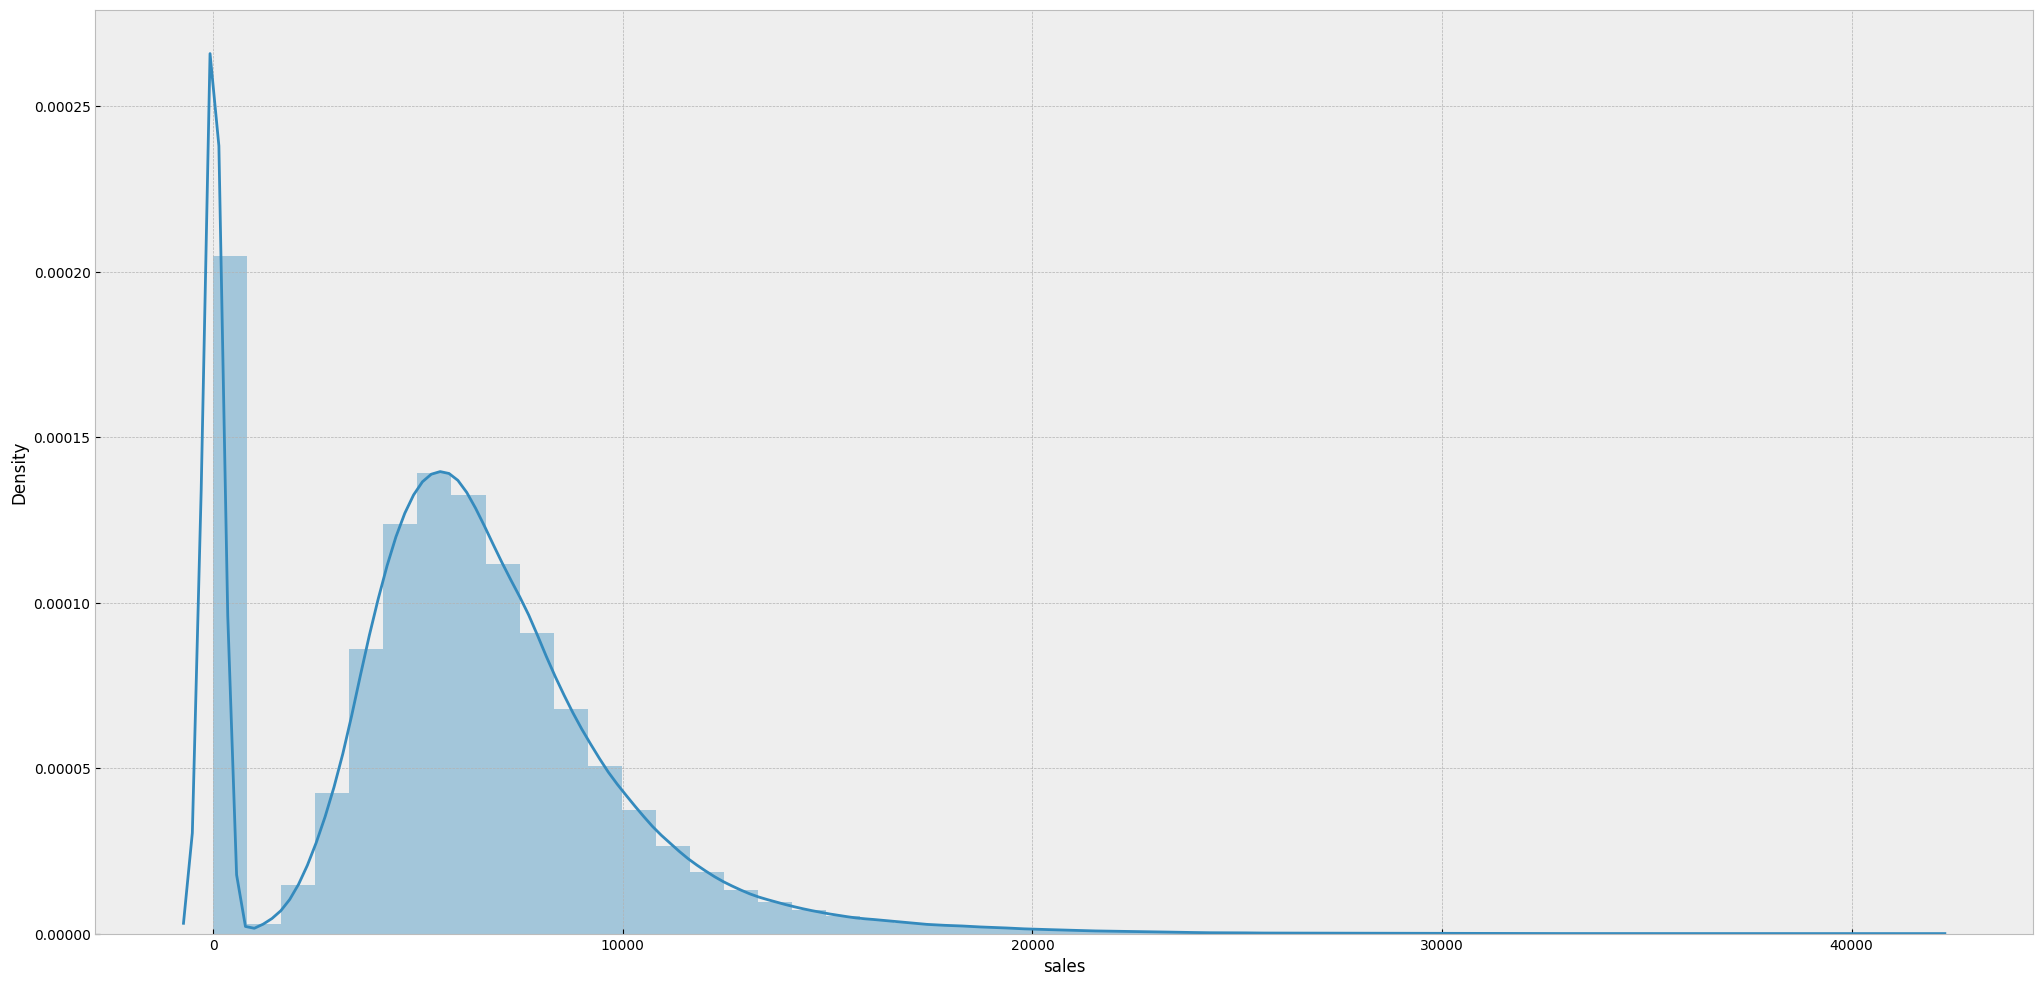

In [19]:
#Checking sales volume
sns.distplot(df1['sales']);

### 1.5.2 Categorical Attributes

In [20]:
#Checking unique categorical values
cat_att.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month             12
dtype: int64

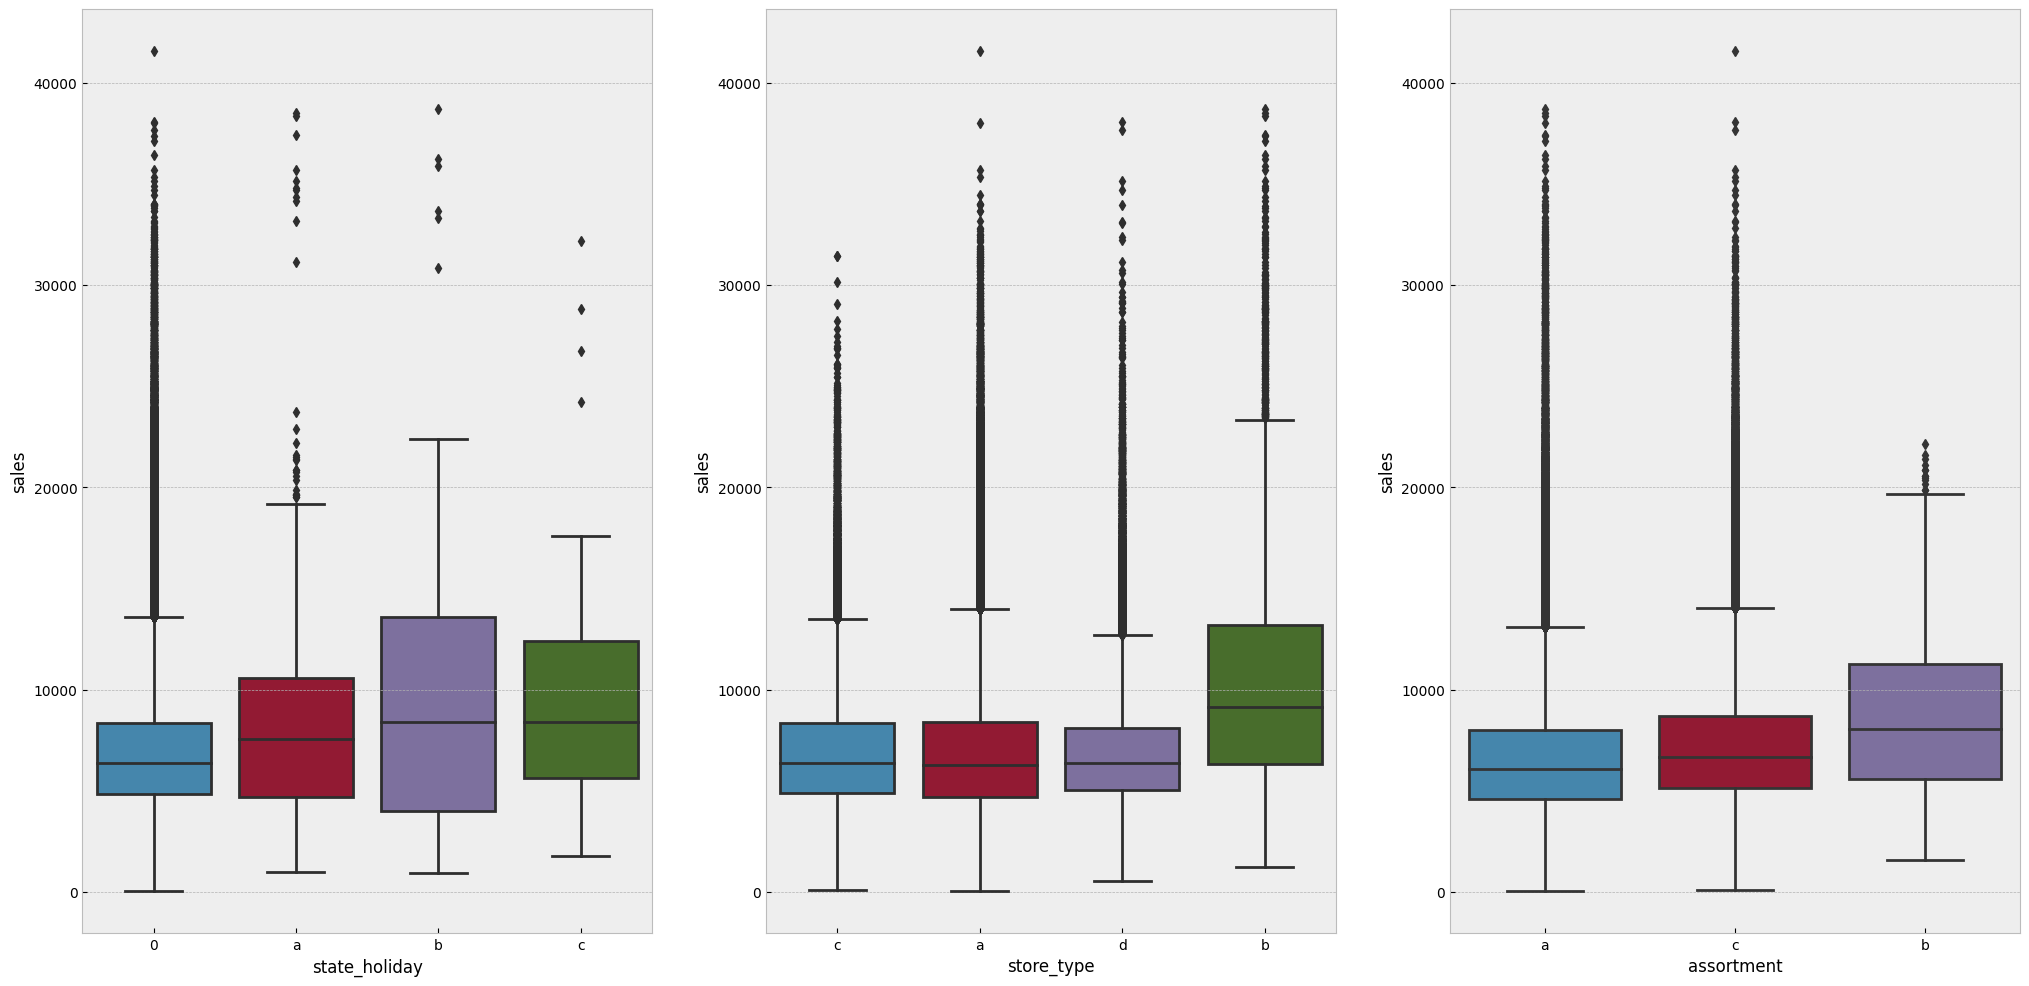

In [21]:
#Checking distribution of categorical attributes
cond = df1[(df1['state_holiday'] != 0) & (df1['sales']>0)]

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=cond)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=cond)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=cond);

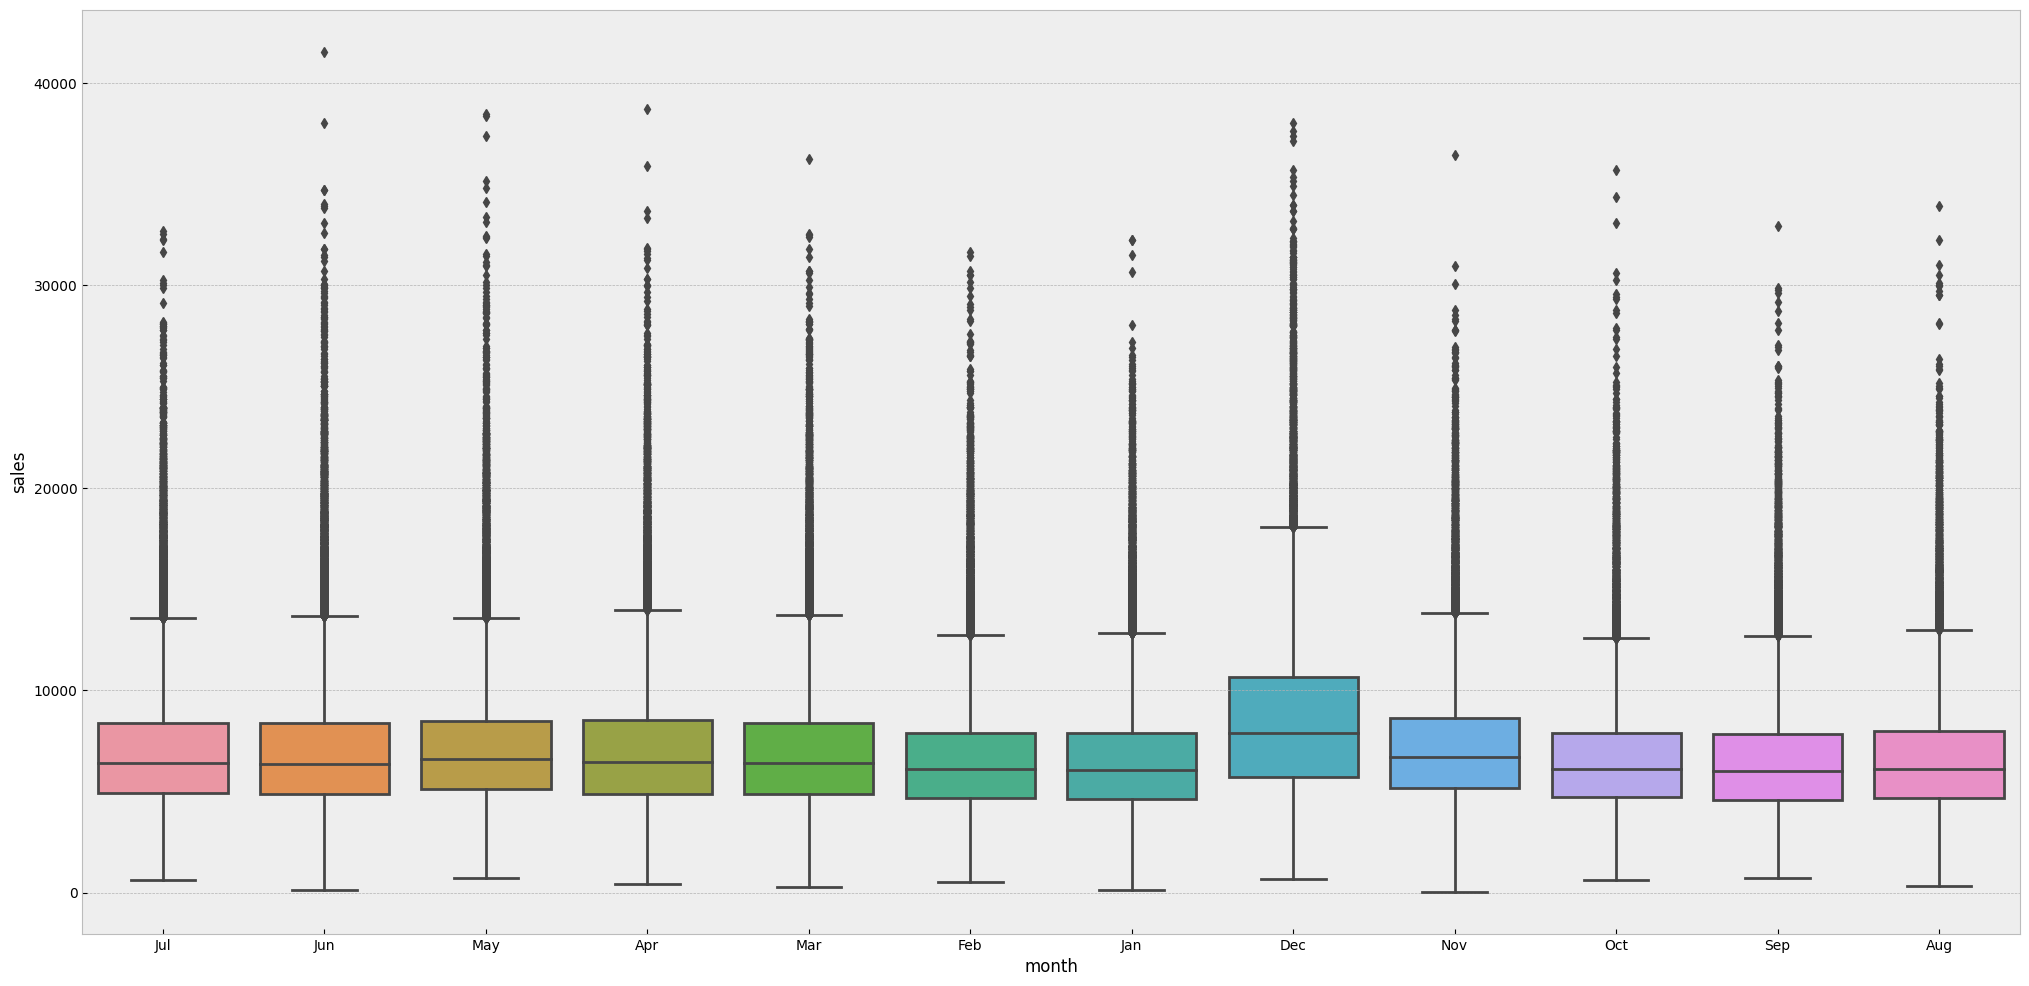

In [22]:
#Checking distribution of sales by month
cond = df1[(df1['state_holiday'] != 0) & (df1['sales']>0)]

sns.boxplot(x='month', y='sales', data=cond);

## 1.7. Pandas Profiling

In [23]:
##Report for External Data Analysis
#prof = ProfileReport(df1)
#prof.to_file(output_file='Profile_Report.html')

# 2.0. Feature Engineering

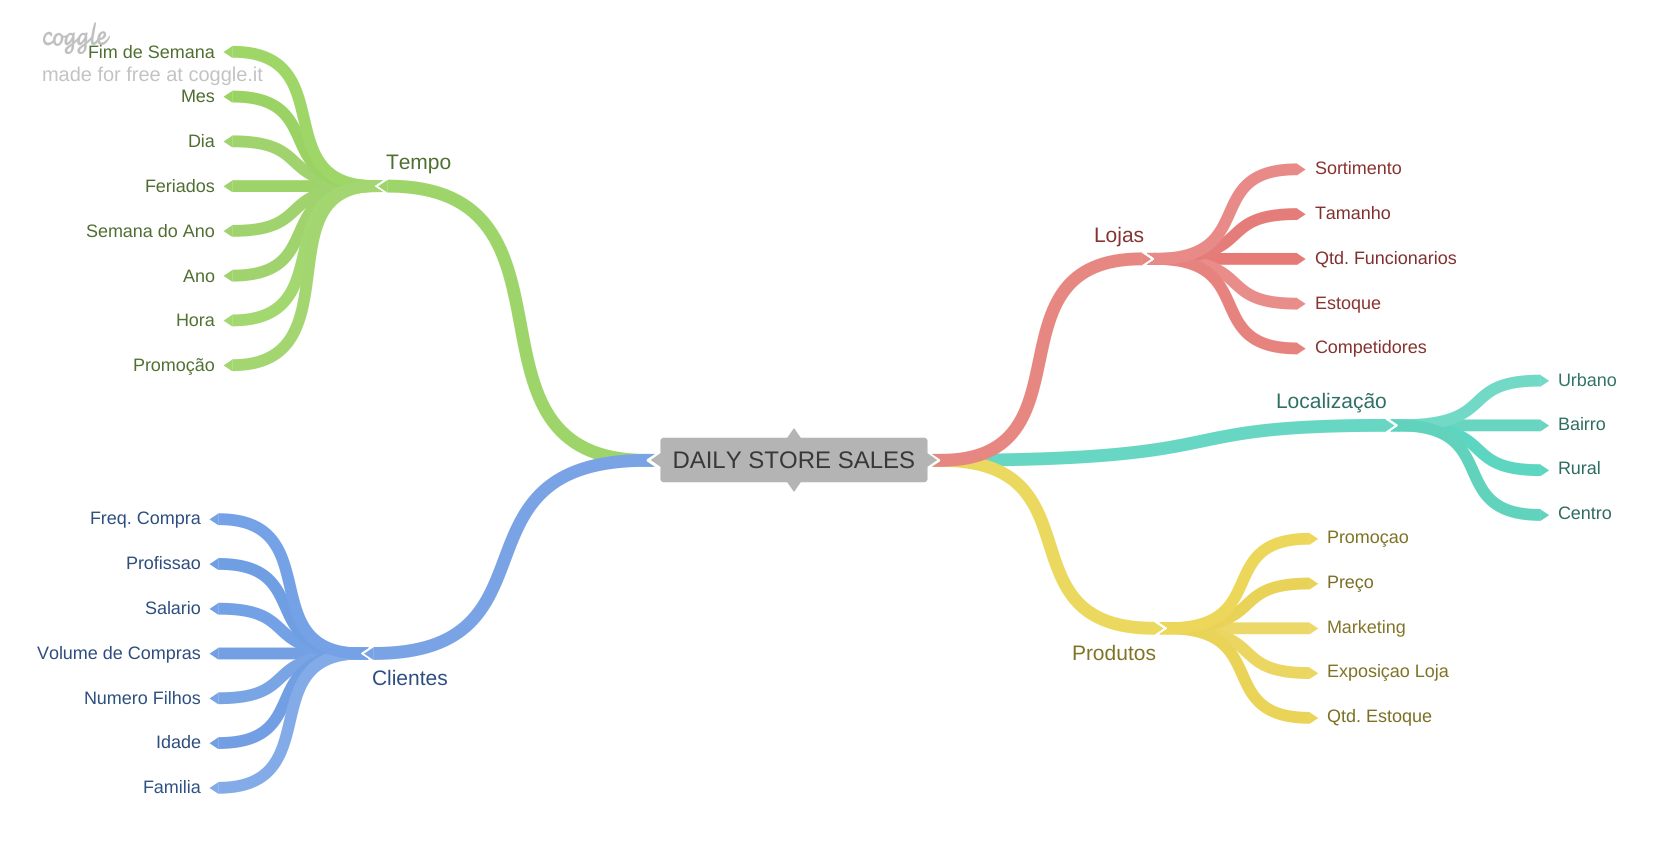

In [24]:
#Load Mind Map
Image('images/mind_map.png')

## 2.1. Hypothesis Definition

### 2.1.1 Store hypothesis

1. Stores with greater assortment should sell more
2. Stores with closer competitors should sell less
3. Stores with competitors for a longer time should sell more
4. Stores with promotions active for a longer time should sell more
5. Stores with more consecutive promotions should sell more

---
In Portuguese Language:

1. Lojas com maior sortimento deveriam vender mais
2. Lojas com competidores mais próximos deveriam vender menos
3. Lojas com competidores há mais tempo deveriam vender mais
4. Lojas com promoções ativas por mais tempo deveriam vender mais
5. Lojas com mais promoções consecutivas deveriam vender mais


### 2.1.2 Time hypothesis

6. Stores open during the Christmas holidays should sell more
7. Stores should sell more over the years
8. Stores should sell more in the second half of the year
9. Stores should sell more after the 10th of every month
10. Stores should sell less on weekends
11. Stores should sell less during school holidays

---
In Portuguese Language:

6. Lojas abertas durante o feriado de Natal deveriam vender mais
7. Lojas deveriam vender mais ao longo dos anos
8. Lojas deveriam vender mais no segundo semestre do ano
9. Lojas deveriam vender mais depois do dia 10 de cada mês
10. Lojas deveriam vender menos aos finais de semana
11. Lojas deveriam vender menos durante feriados escolares

In [25]:
#Dataset backup
df2 = df1.copy()

In [26]:
#Dataset Feature Engineering
df2 = feature_eng(df2)

# 3.0. Data Filtering

In [27]:
#Dataset Filtering

#Dataset backup
df3 = df2.copy()

## 3.1. Rows Filtering

In [28]:
#Filtering all the data with open stores and has sales
print('Rows Before Filtering: {}'.format(df3.shape[0]))

#Filtering only Open Stores with at least One Sell
cond = (df3['open'] != 0) & (df3['sales'] > 0)
df3 = df3[cond]

#Checking total of rows after filtering
print('Rows After Filtering: {}'.format(df3.shape[0]))

Rows Before Filtering: 1017209
Rows After Filtering: 844338


## 3.2. Columns Filtering

In [29]:
#Filtering relevant columns for algoritms application
print('Columns Before Filtering: {}'.format(df3.shape[1]))
cols_drop = ['customers', 'open', 'promo_interval']
df3 = df3.drop(cols_drop, axis=1)

#Checking total of columns after filtering
print('Columns After Filtering: {}'.format(df3.shape[1]))

Columns Before Filtering: 28
Columns After Filtering: 25


# 4.0. Exploratory Data Analysis (EDA)

In [30]:
#Dataframe Preparation for Machine Learning Algorithms

#Dataset backup
df4 = df3.copy()

### 4.1 Univariate Analysis

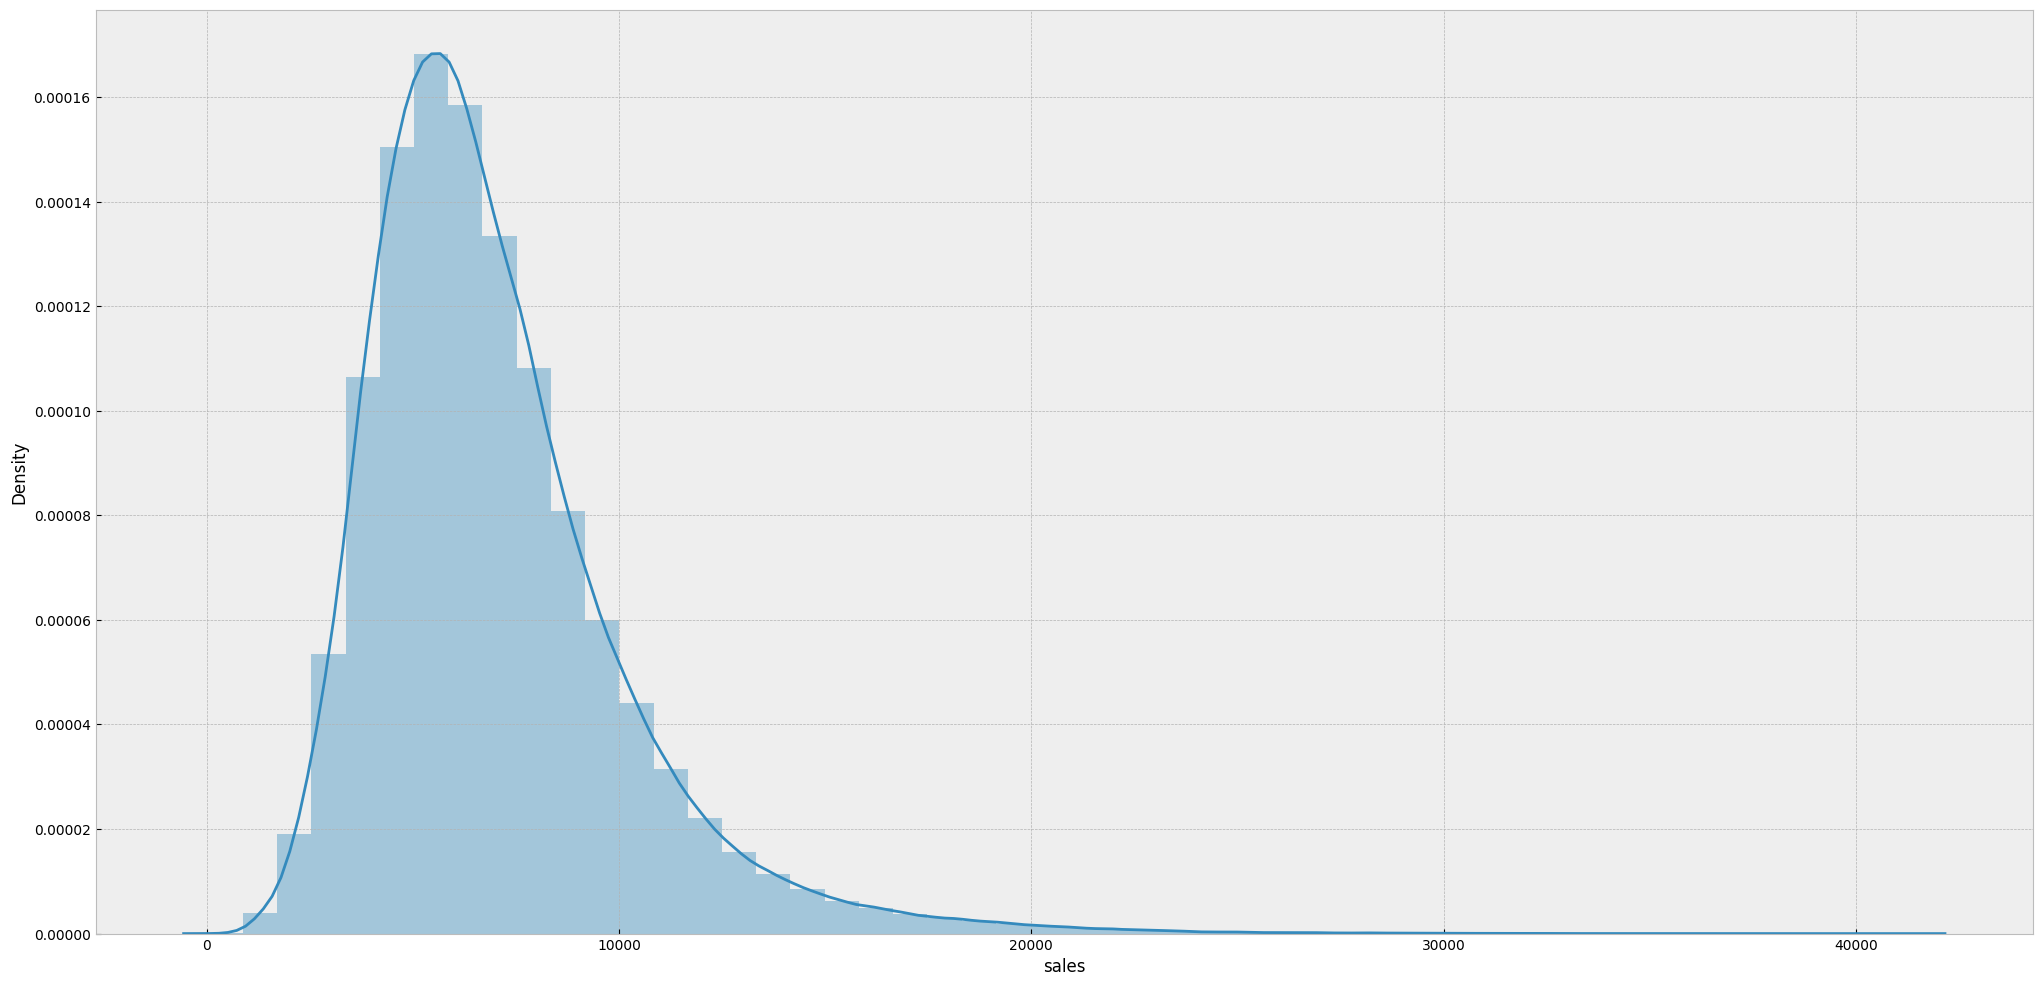

In [31]:
#Response Variable
sns.distplot(df4['sales']);

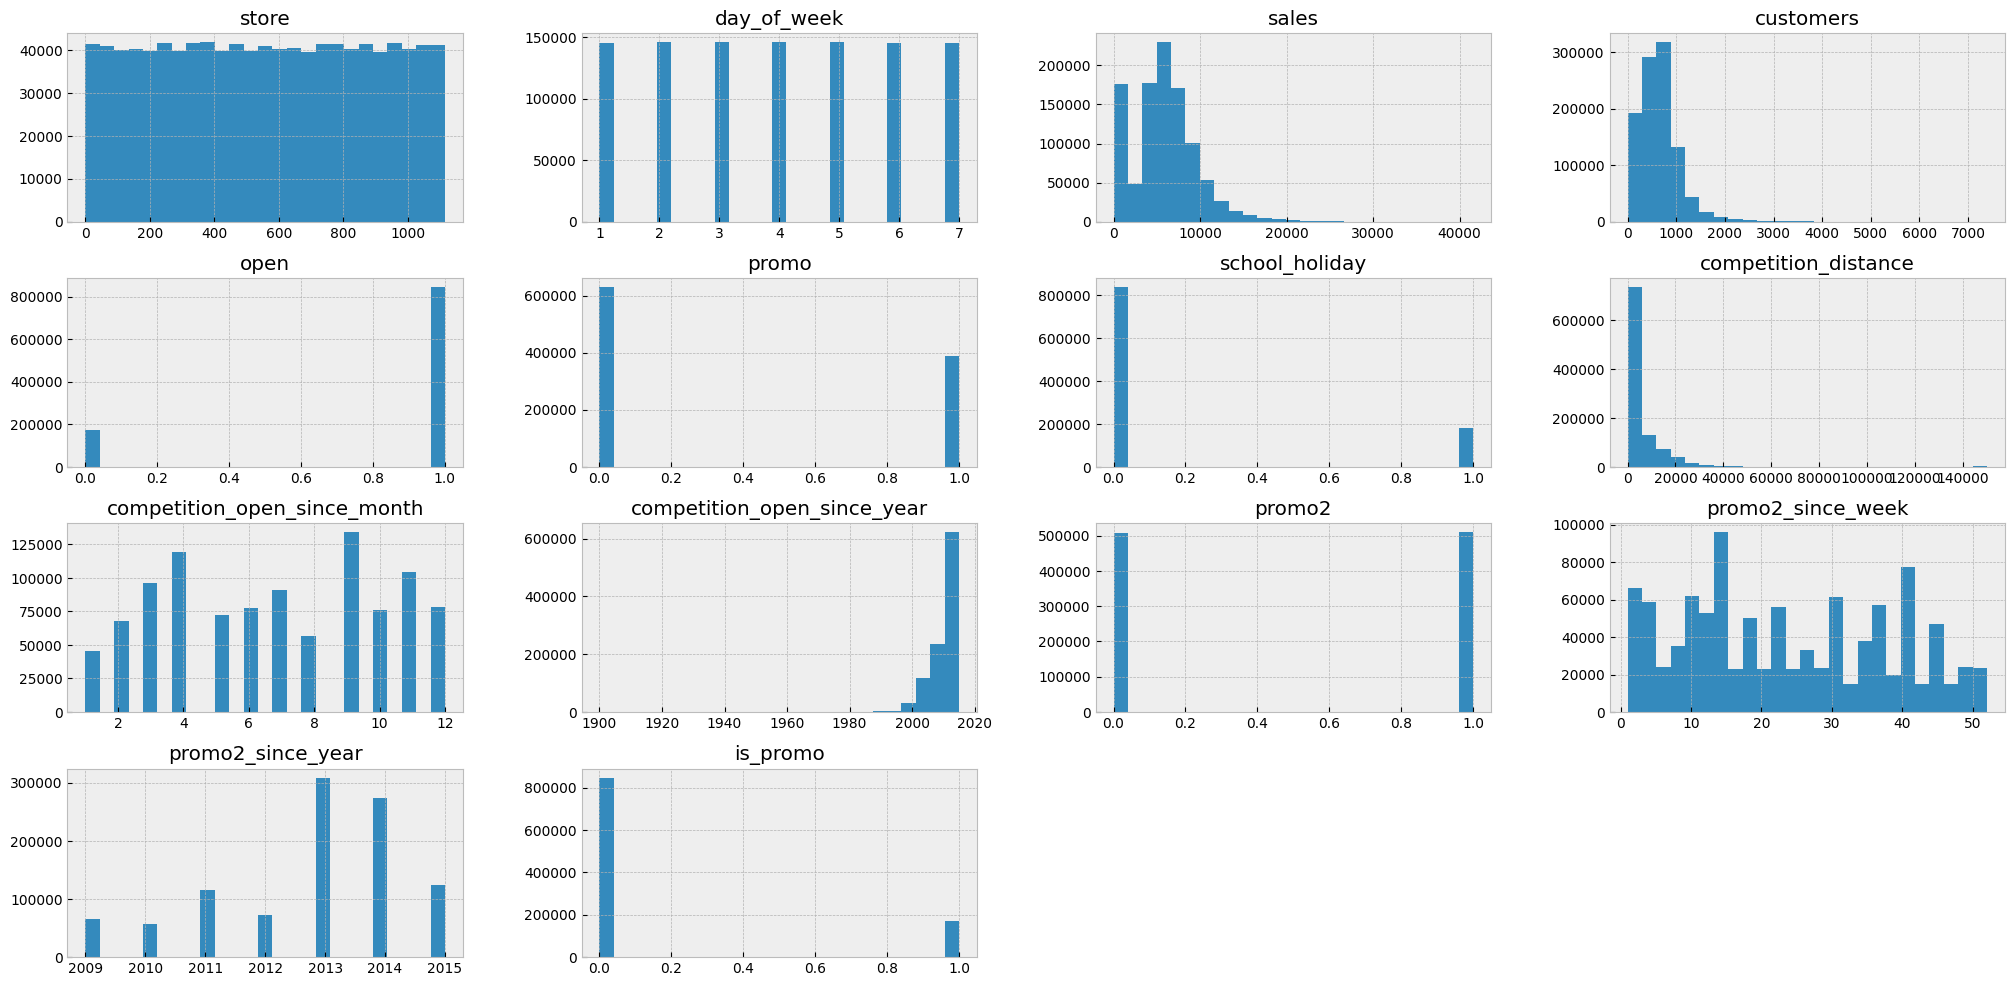

In [32]:
#Checking Numerical Variables on graphs
num_att.hist(bins=25);

In [33]:
#Checking Categorical Variables - Data Adjust for Further Analysis
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

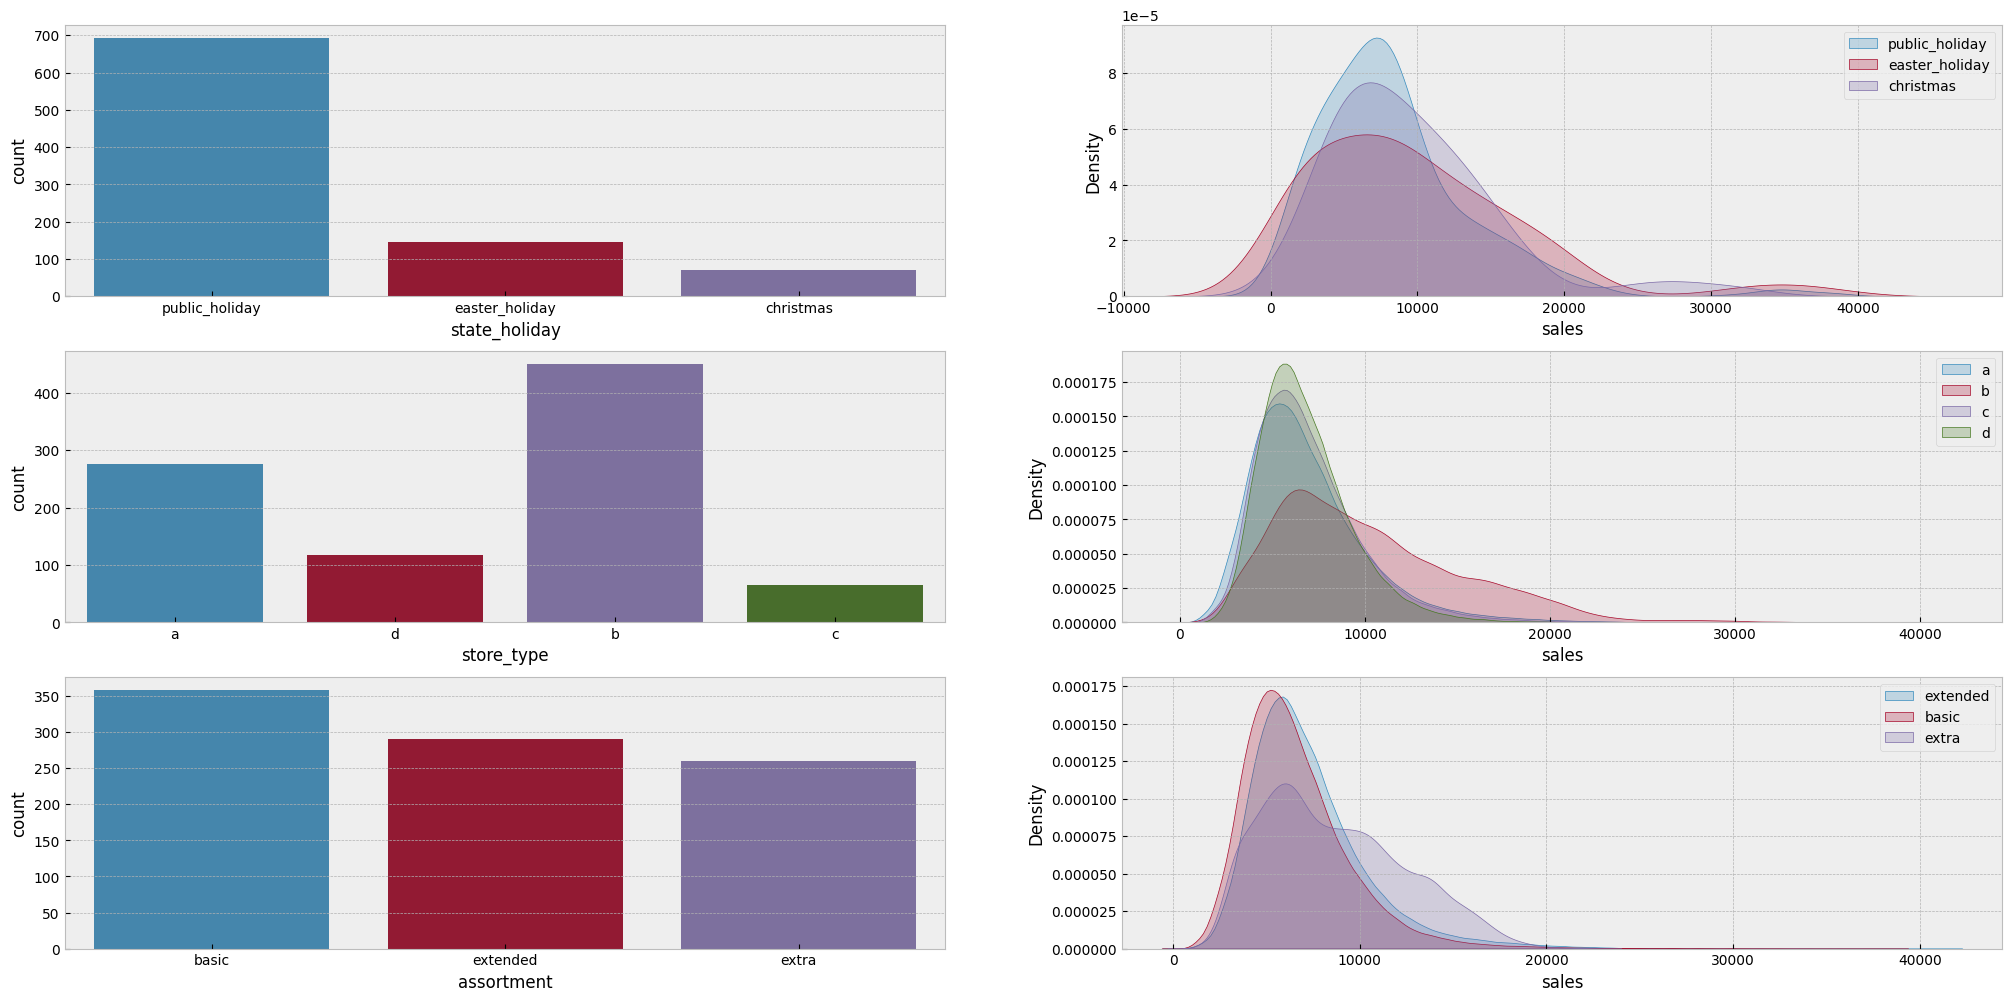

In [34]:
#Plotting State Holiday Data
plt.subplot(3,2,1)
cond = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(x=cond['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', fill=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', fill=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', fill=True)
plt.legend()

#Plotting Store Type Data
plt.subplot(3,2,3)
sns.countplot(x=cond['store_type']);

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', fill=True)
plt.legend()


#Plotting Assortment Data
plt.subplot(3,2,5)
sns.countplot(x=cond['assortment']);

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', fill=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', fill=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', fill=True)

#Include legend
plt.legend();

### 4.2 Bivariate Analysis

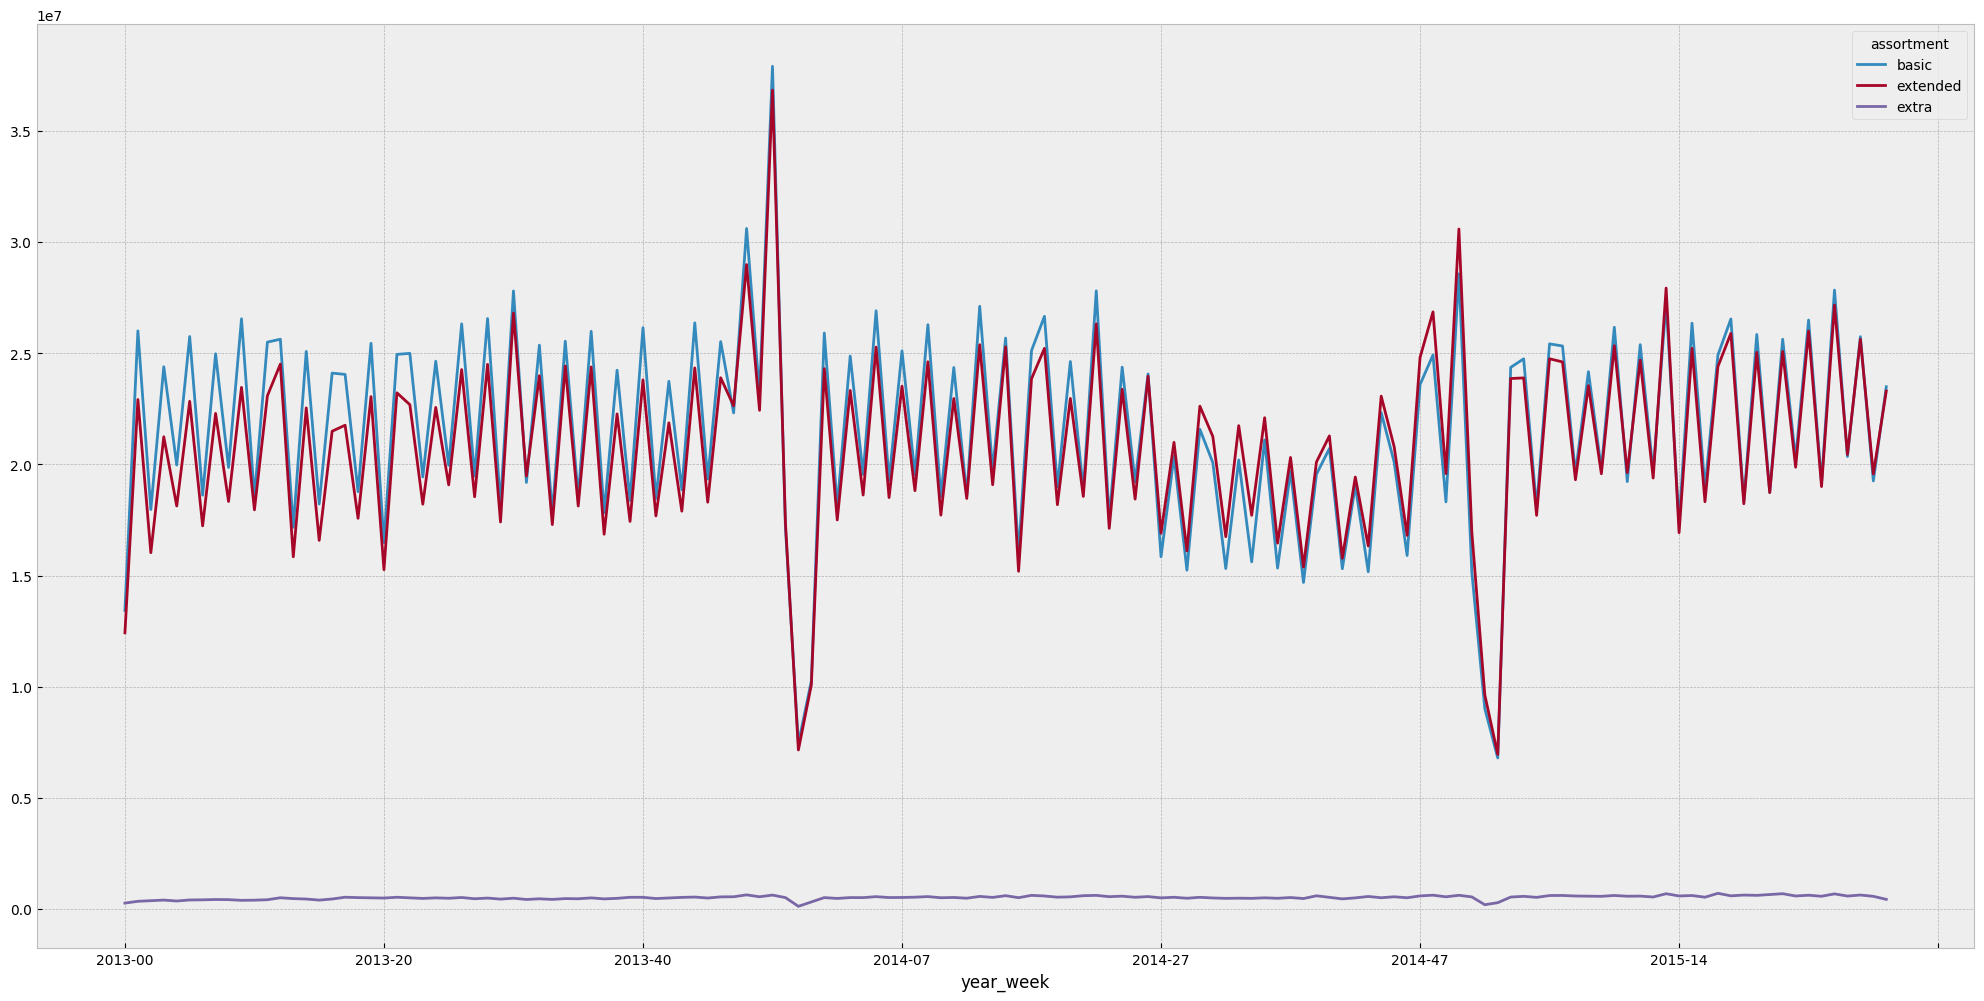

In [35]:
#Hypothesis Analysis
#1. Stores with greater assortment should sell more (No - Hypothesis Rejected)
aux1 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux1.pivot(index='year_week', columns='assortment', values='sales').plot();

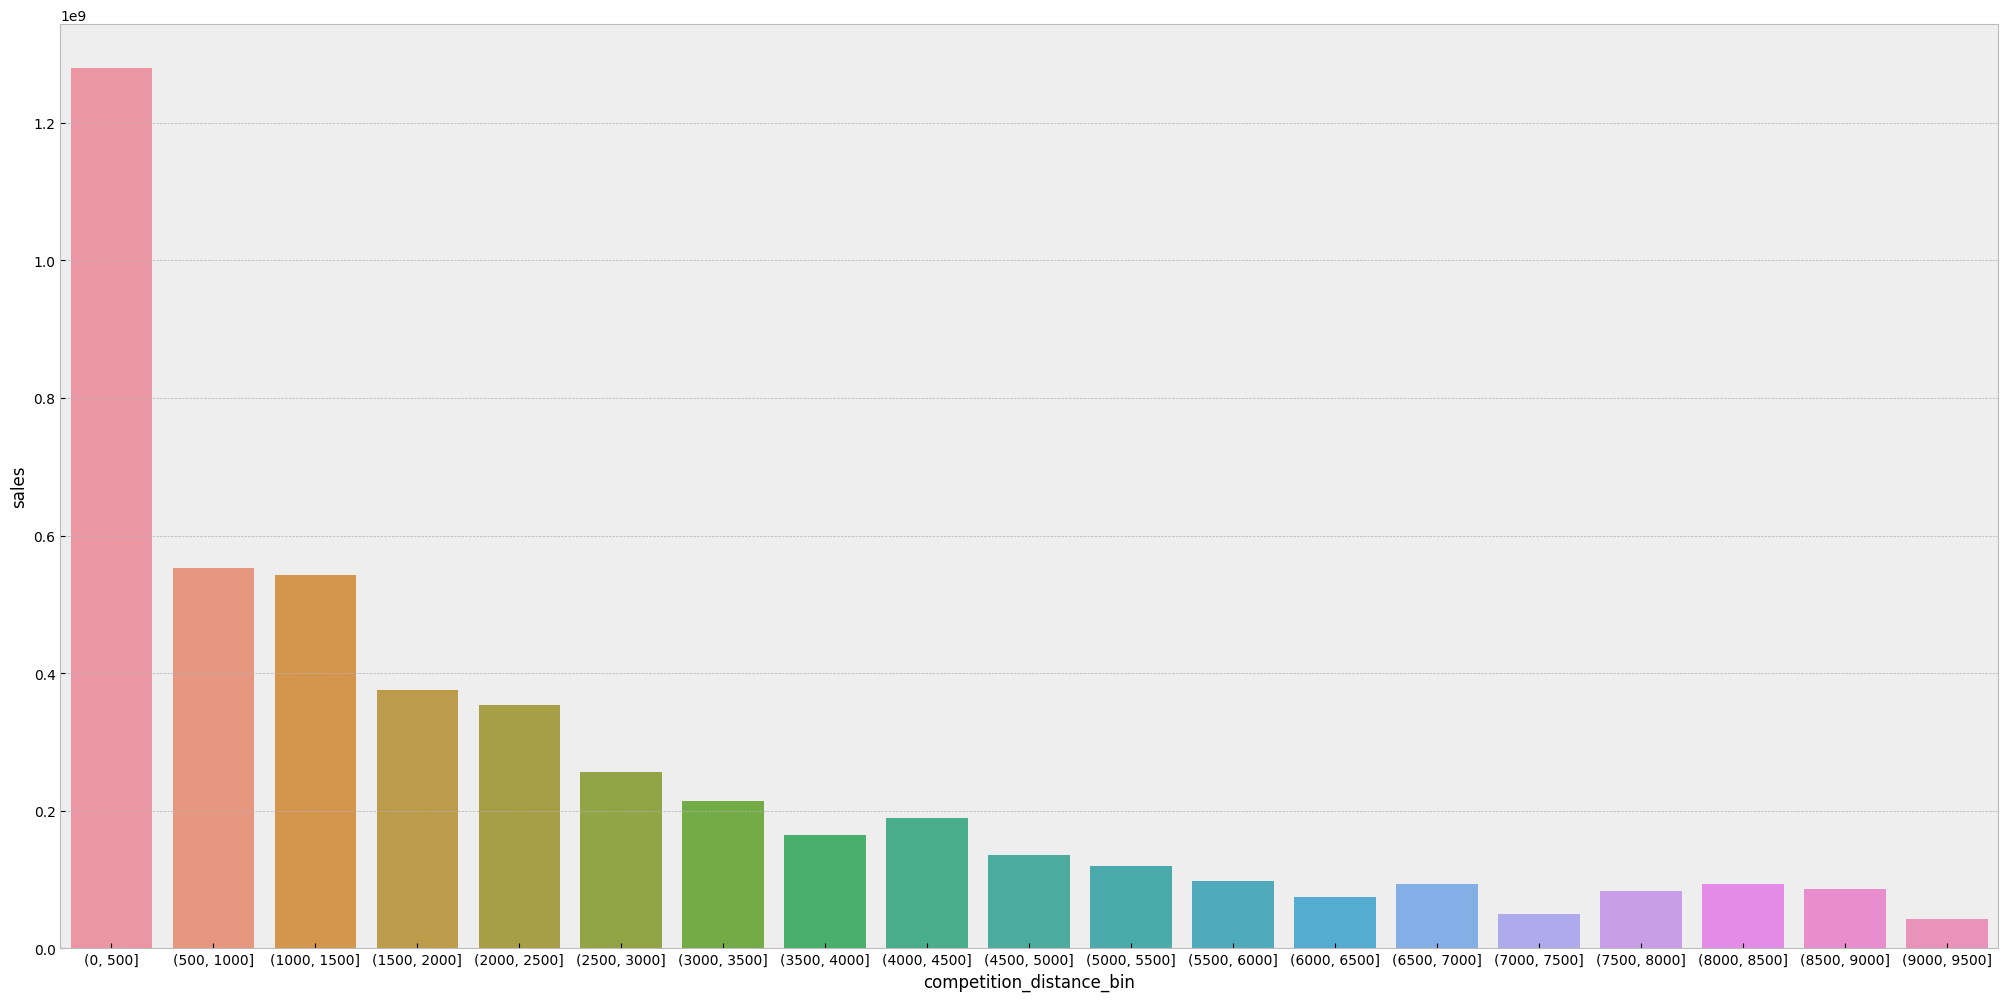

In [36]:
#Hypothesis Analysis
#2. Stores with closer competitors should sell less (No - Hypothesis Rejected)
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

#Adjusting range of data to facilitate the visualization on plottting
bins = list(np.arange(0, 10000, 500))

aux1['competition_distance_bin'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_bin', 'sales']].groupby('competition_distance_bin').sum().reset_index()

sns.barplot(x='competition_distance_bin', y='sales', data=aux2);

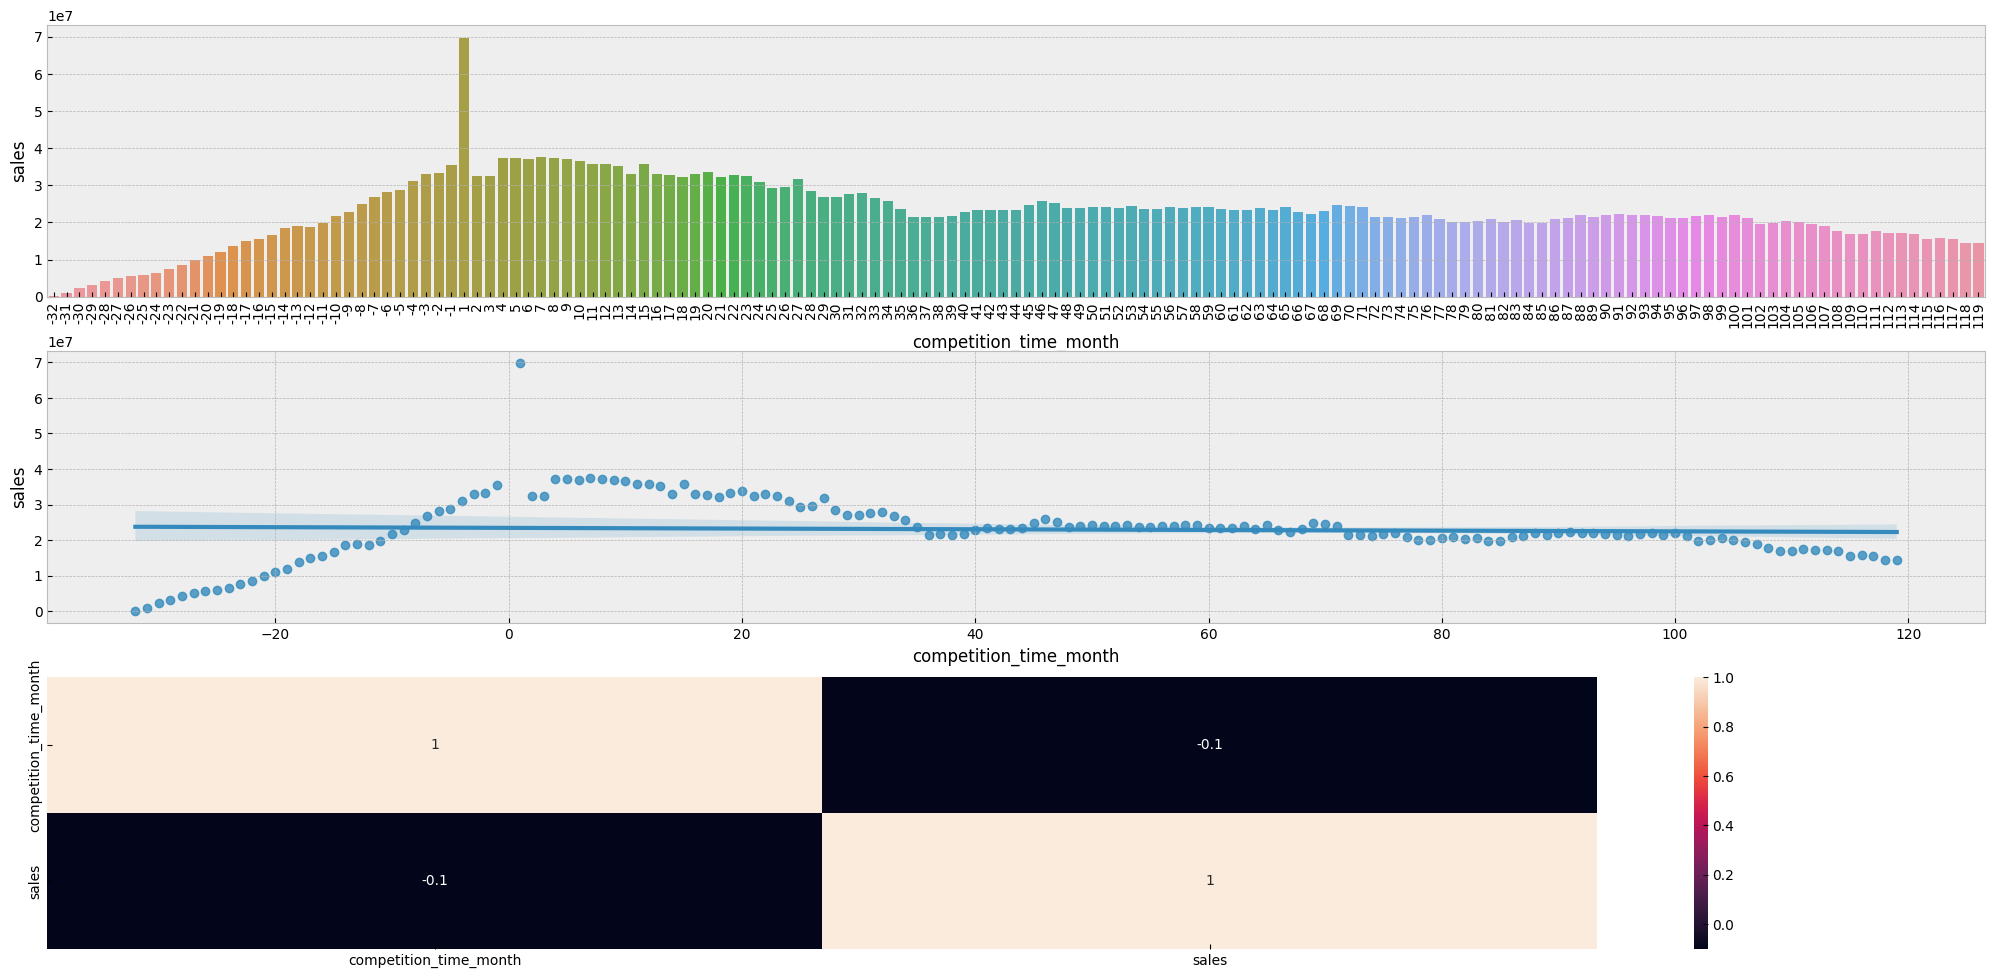

In [37]:
#Hypothesis Analysis
#3. Stores with competitors for a longer time should sell more (No - Hypothesis Rejected)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month']<120) & (aux1['competition_time_month']!=0)]

#Plotting Bars of data of competition_time_month by sales
plt.subplot(3,1,1)
sns.barplot(x='competition_time_month', y='sales', data=aux2)
plt.xticks(rotation=90)

#Plotting Linear Regression relationship of data of competition_time_month by sales
plt.subplot(3,1,2)
sns.regplot(x='competition_time_month', y='sales', data=aux2)

#Plotting Correlation of data of competition_time_month by sales
plt.subplot(3,1,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

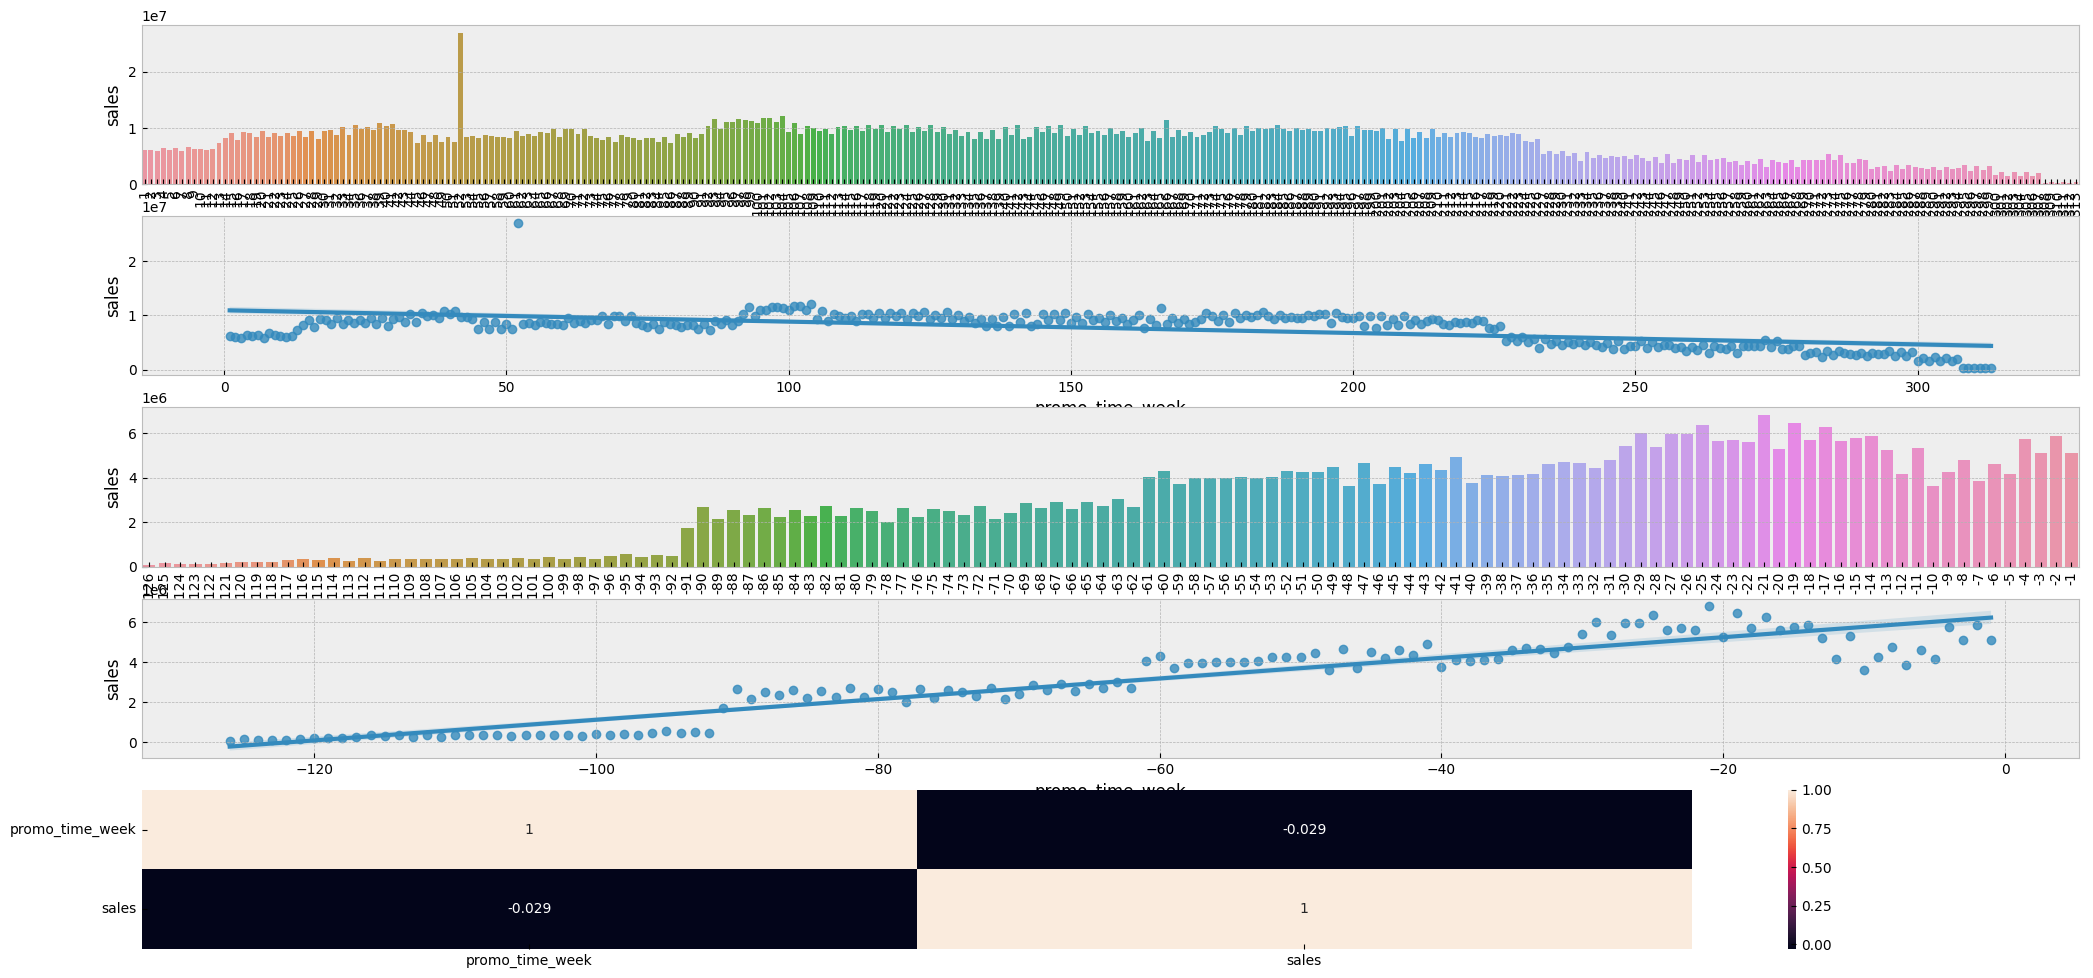

In [38]:
#Hypothesis Analysis
#4. Stores with promotions active for a longer time should sell more (No - Hypothesis Rejected)
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

#Define GridSpec to Plot Data
grid = GridSpec(5,1)

#Plotting of Extended Promotion
plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week']>0]
sns.barplot(x='promo_time_week', y='sales', data=aux2)
plt.xticks(rotation=90)

plt.subplot(grid[1,0])
sns.regplot(x='promo_time_week', y='sales', data=aux2)

#Plotting of Regular Promotion
plt.subplot(grid[2,0])
aux3 = aux1[aux1['promo_time_week']<0]
sns.barplot(x='promo_time_week', y='sales', data=aux3)
plt.xticks(rotation=90)

plt.subplot(grid[3,0])
sns.regplot(x='promo_time_week', y='sales', data=aux3)

#Variable Correlation analysis of promo_time_week
plt.subplot(grid[4,0])
sns.heatmap(aux1.corr(method='pearson'), annot=True);

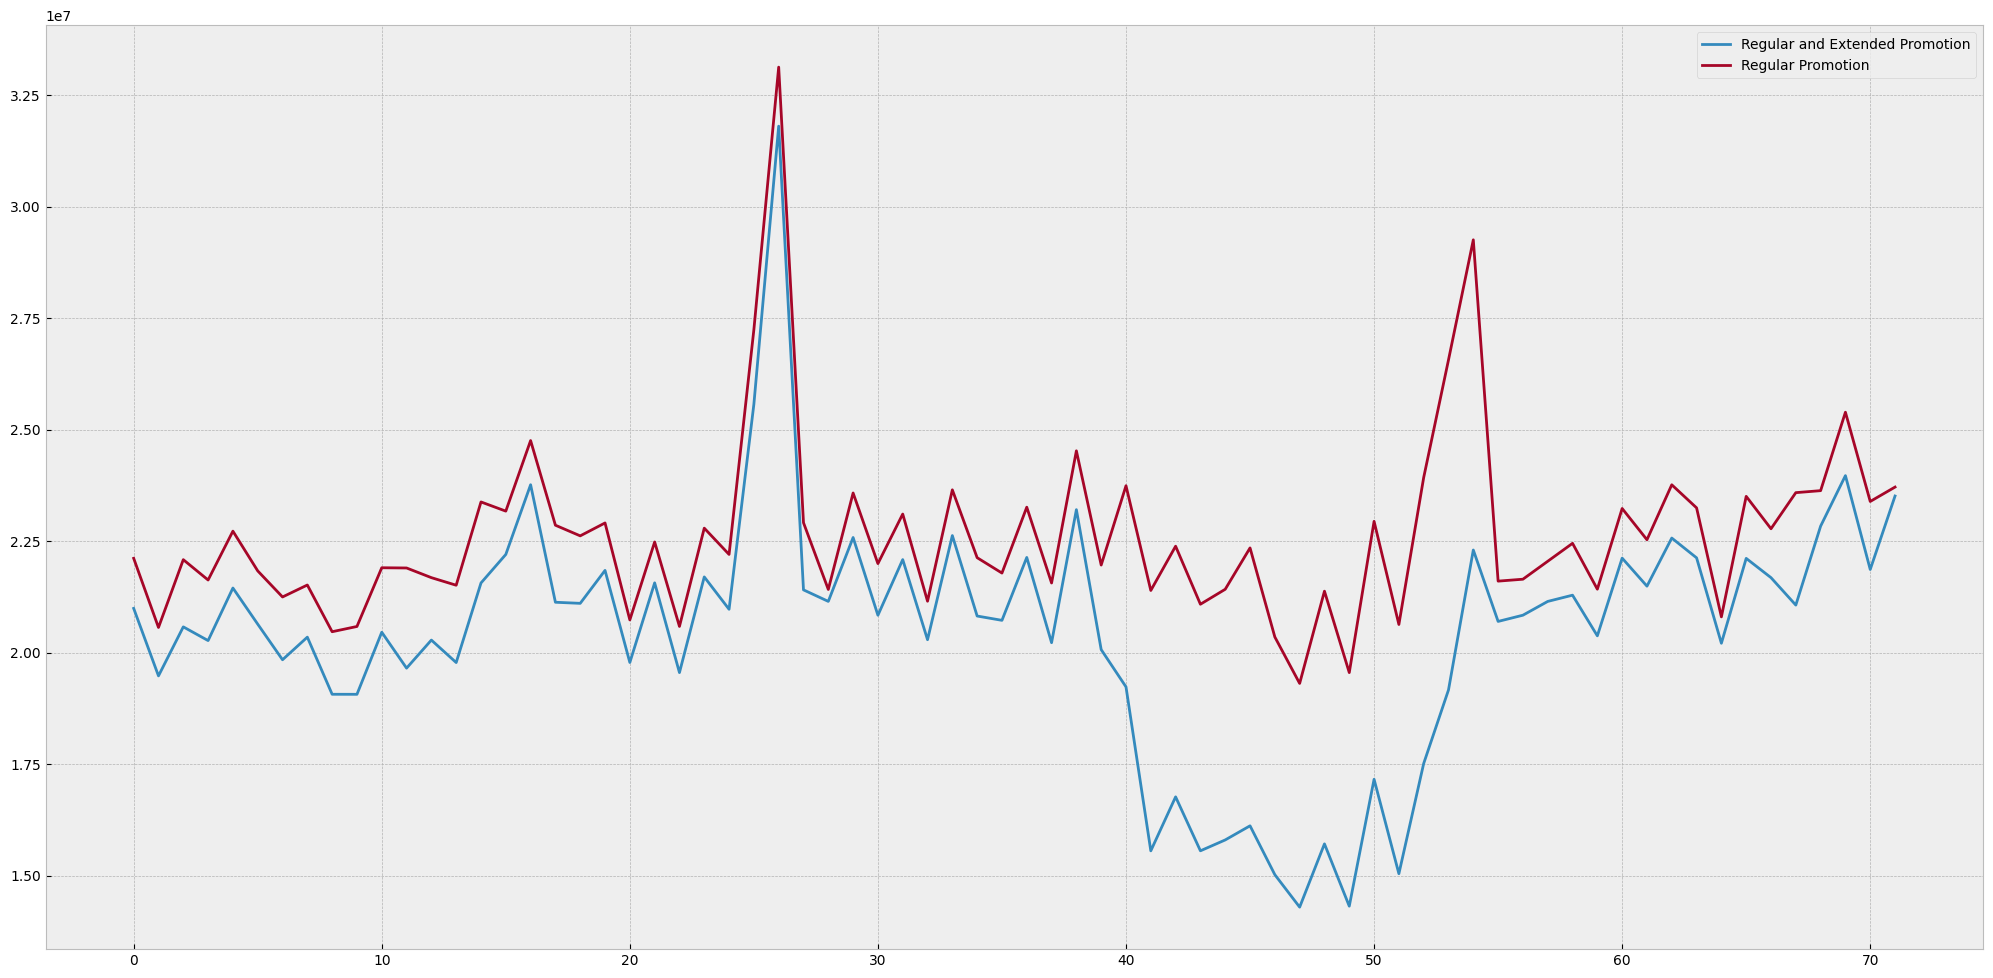

In [39]:
#Hypothesis Analysis
#5. Stores with more consecutive promotions should sell more (No - Hypothesis Rejected)

#Data filter for plotting Regular and Extended Promotion
aux1 = df4[(df4['promo']==1) & (df4['promo2']==1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

#Data filter for plotting Regular Promotion
aux2 = df4[(df4['promo']==1) & (df4['promo2']==0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

#Include legend
ax.legend(labels=['Regular and Extended Promotion', 'Regular Promotion']);

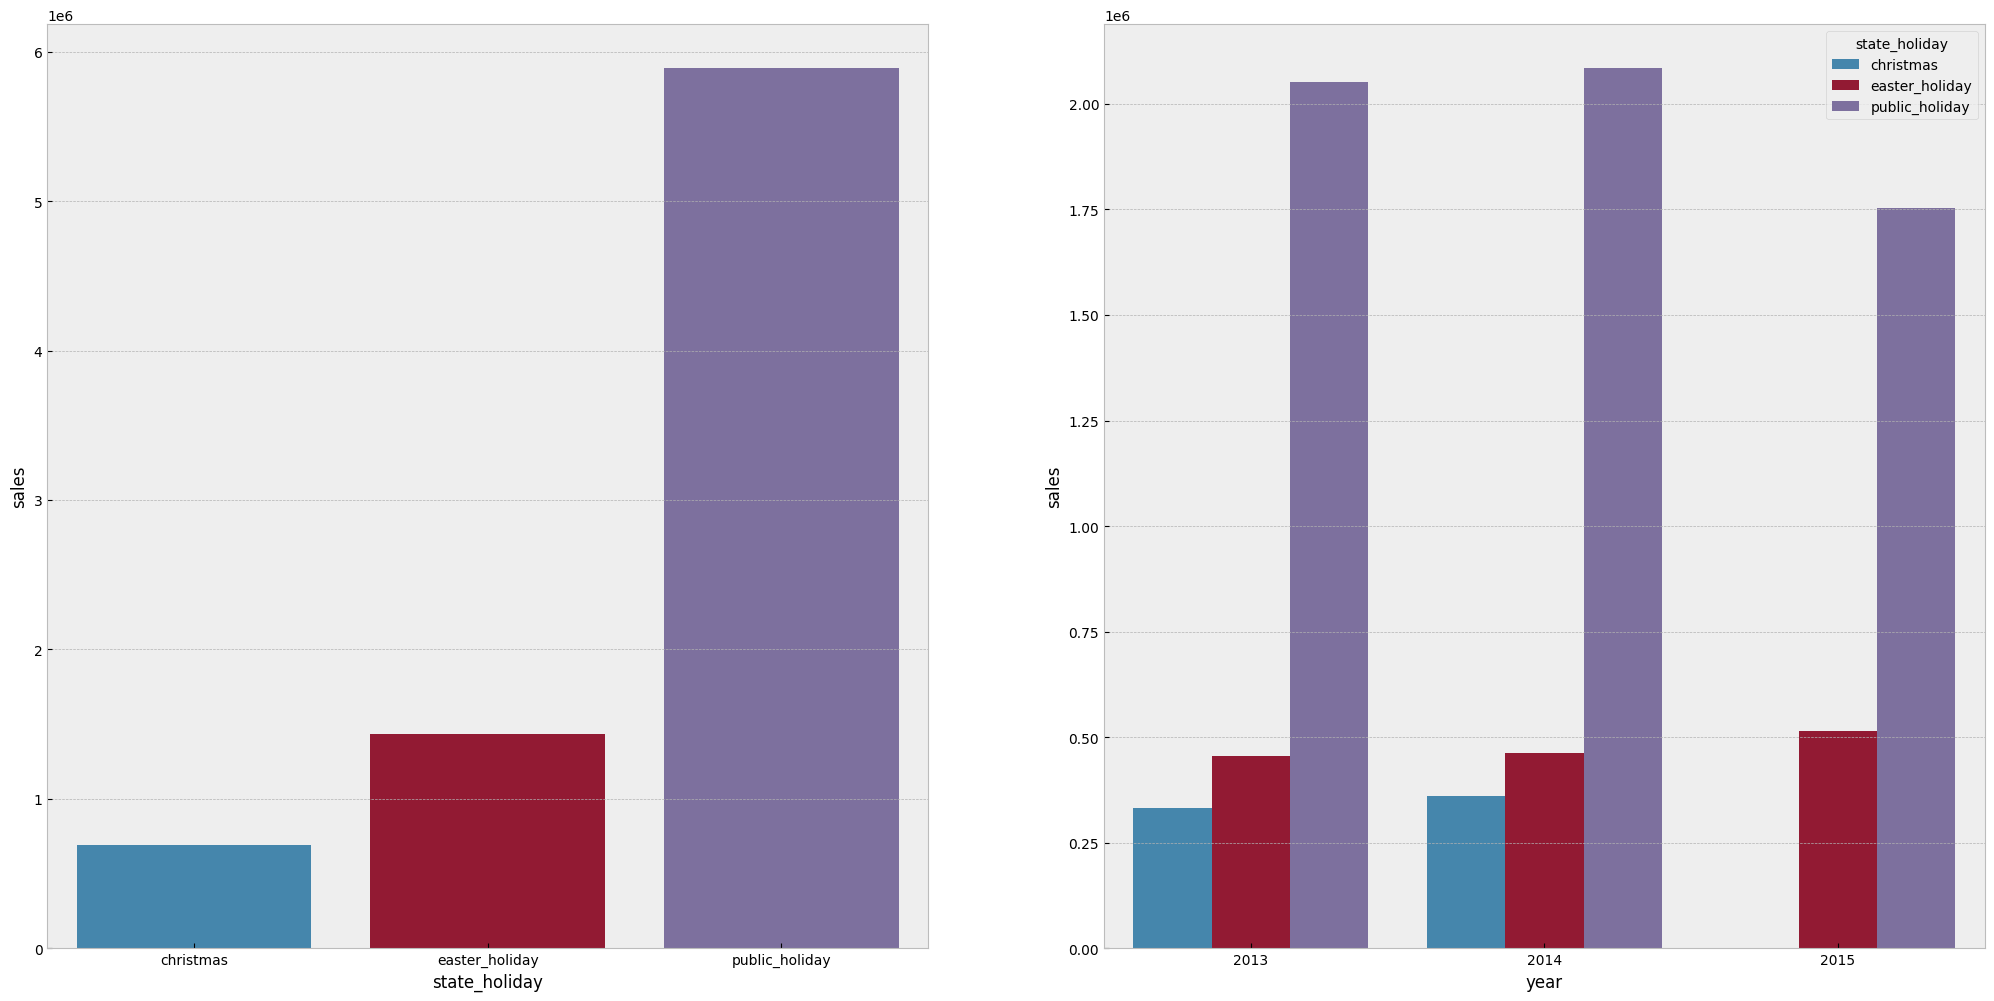

In [40]:
#Hypothesis Analysis
#6. Stores open during the Christmas holidays should sell more (No - Hypothesis Rejected)

#Data Filtering for consider only Holidays
aux = df4[df4['state_holiday']!='regular_day']

#Plotting Sales x Holiday Types
plt.subplot(1,2,1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1)

#Plotting Sales x Holiday Types per Year
plt.subplot(1,2,2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2);

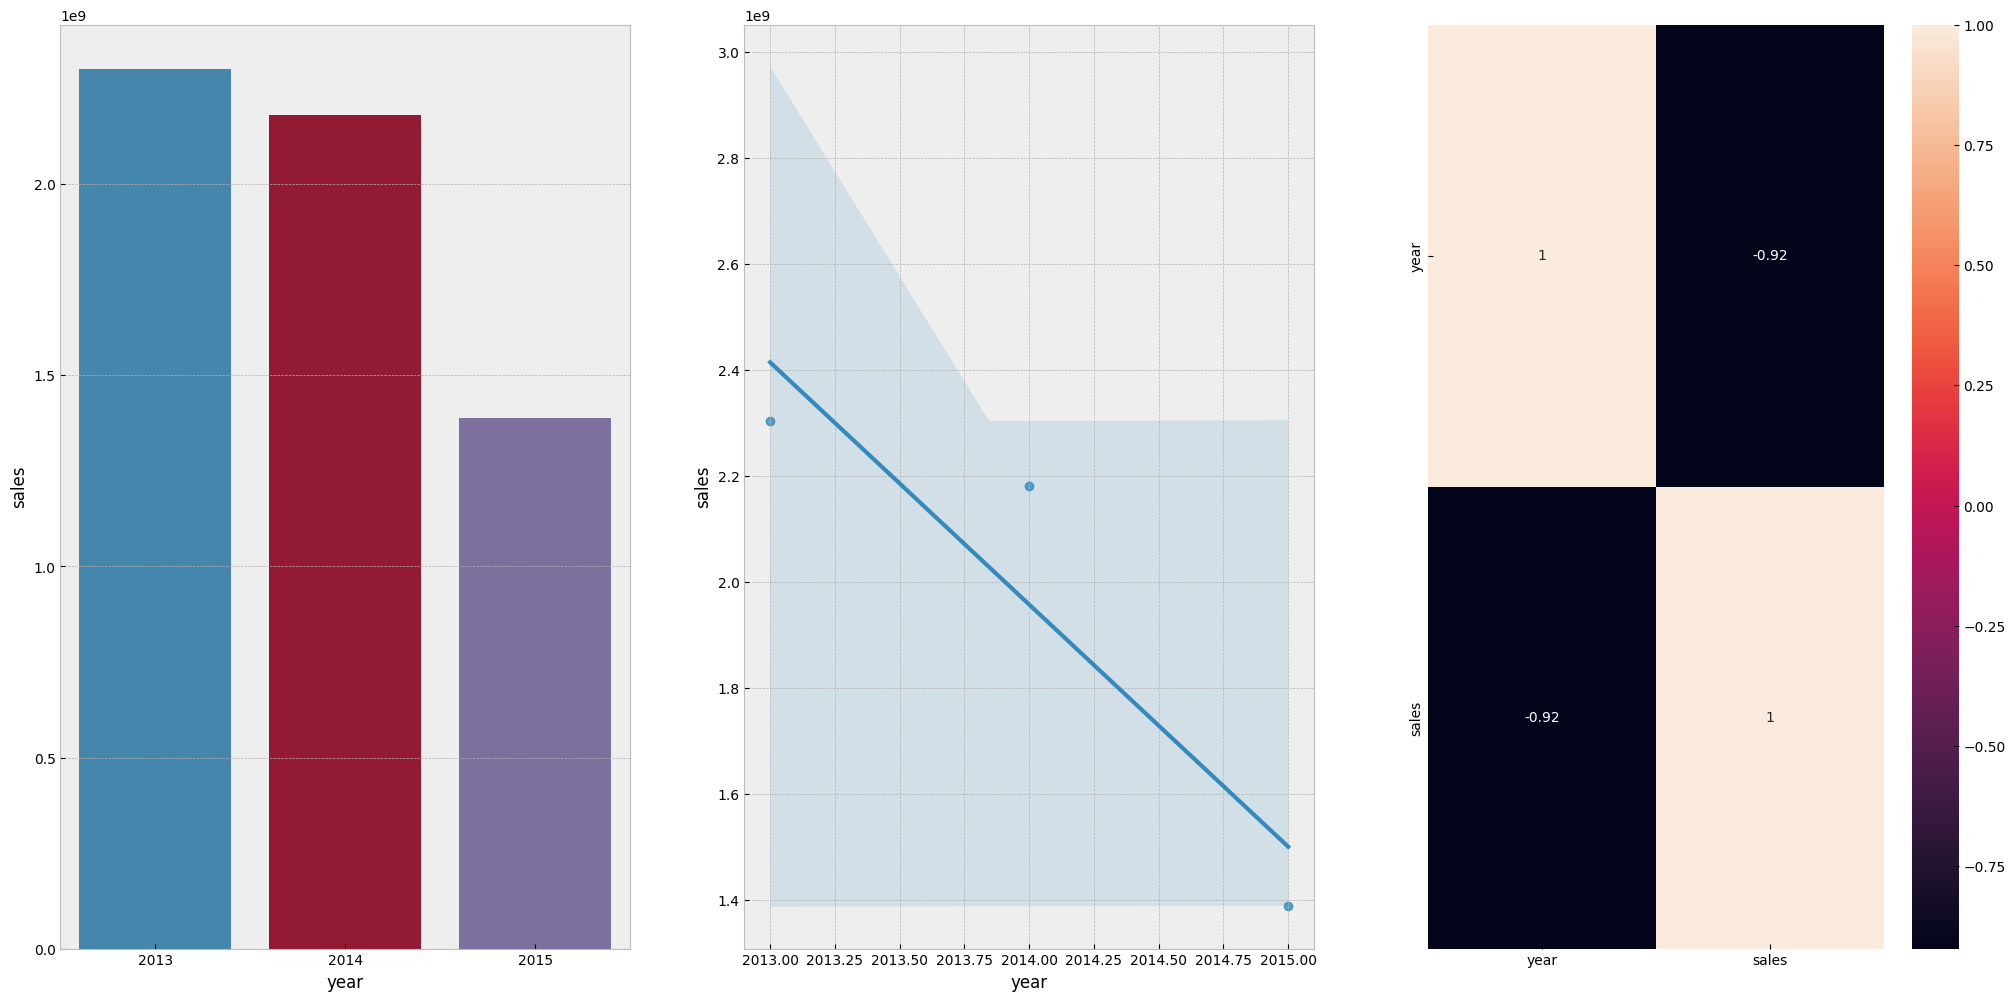

In [41]:
#Hypothesis Analysis
#7. Stores should sell more over the years (No - Hypothesis Rejected)
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

#Plotting Sales x Year
plt.subplot(1,3,1)
sns.barplot(x='year', y='sales', data=aux1)

#Plotting Sales x Year Regression
plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data=aux1)

#Plotting Sales x Year Correlation
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

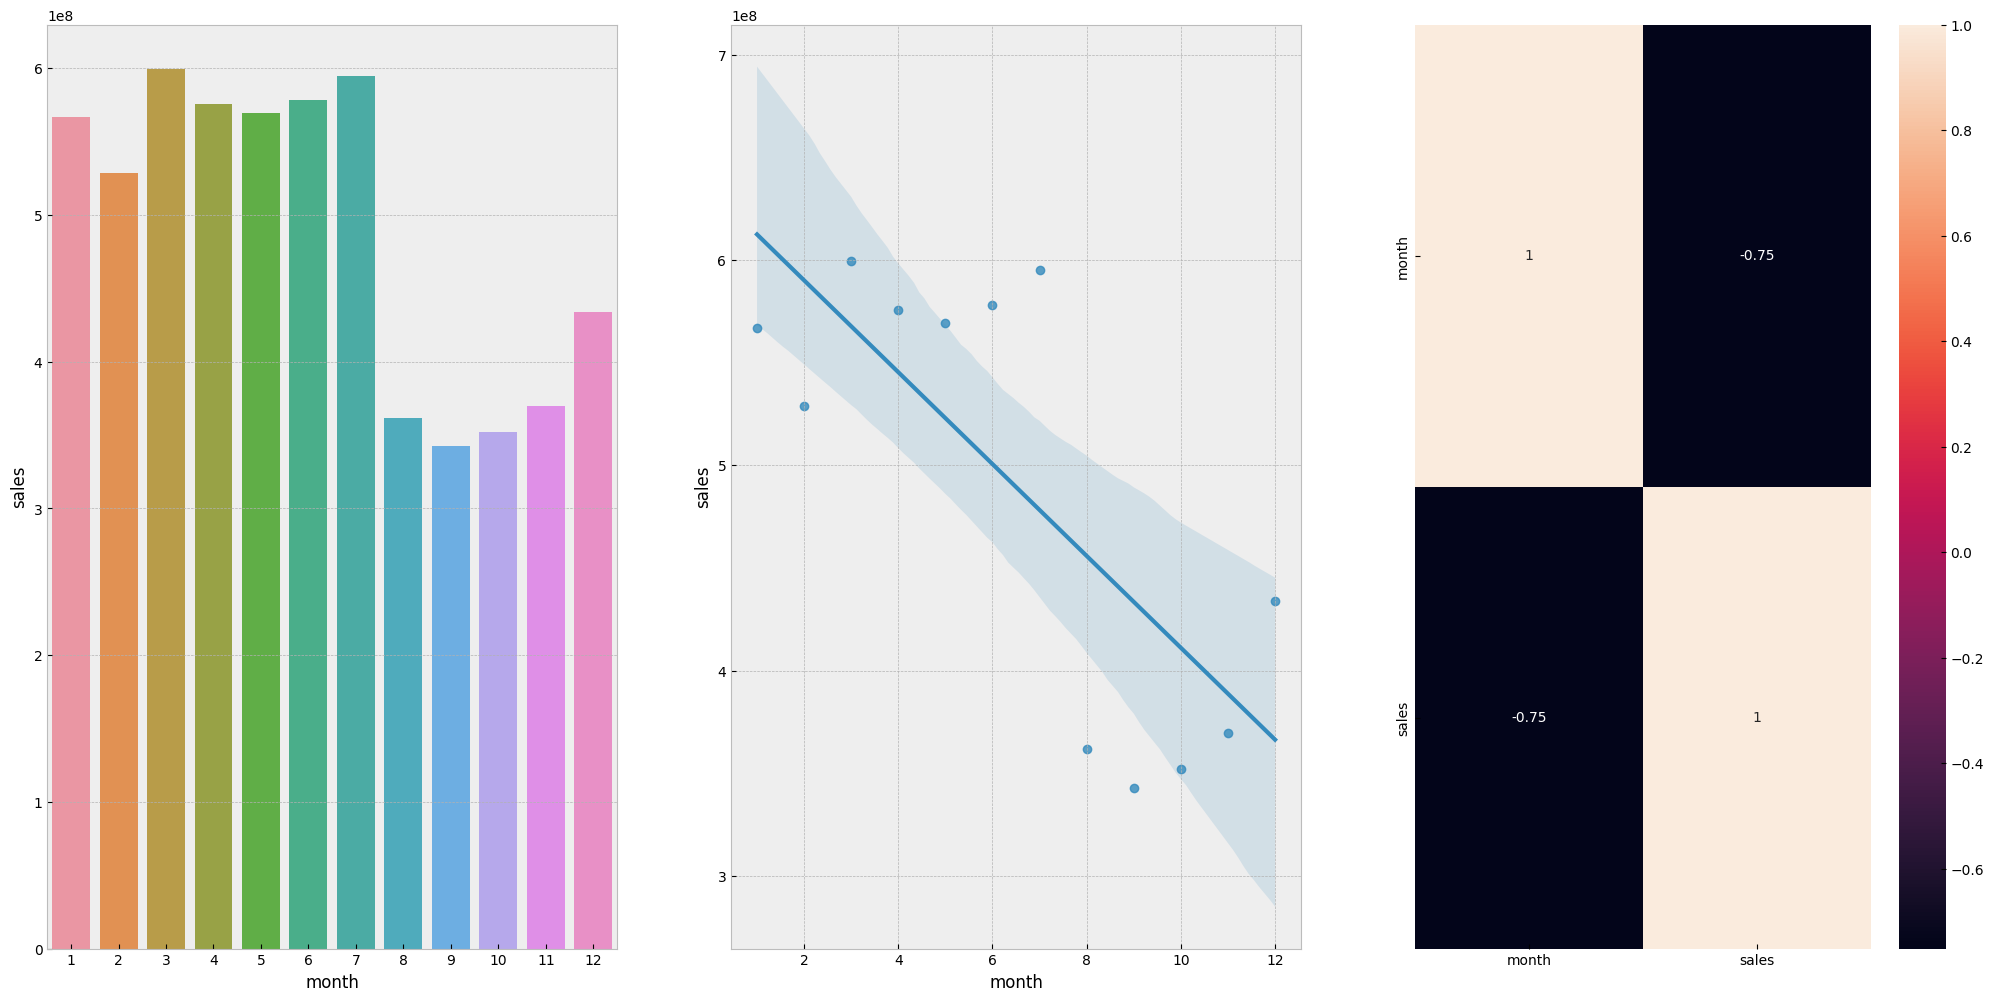

In [42]:
#Hypothesis Analysis
#8. Stores should sell more in the second half of the year (No - Hypothesis Rejected)
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

#Plotting Sales x Month
plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', data=aux1)

#Plotting Sales x Month Regression
plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data=aux1)

#Plotting Sales x Month Correlation
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

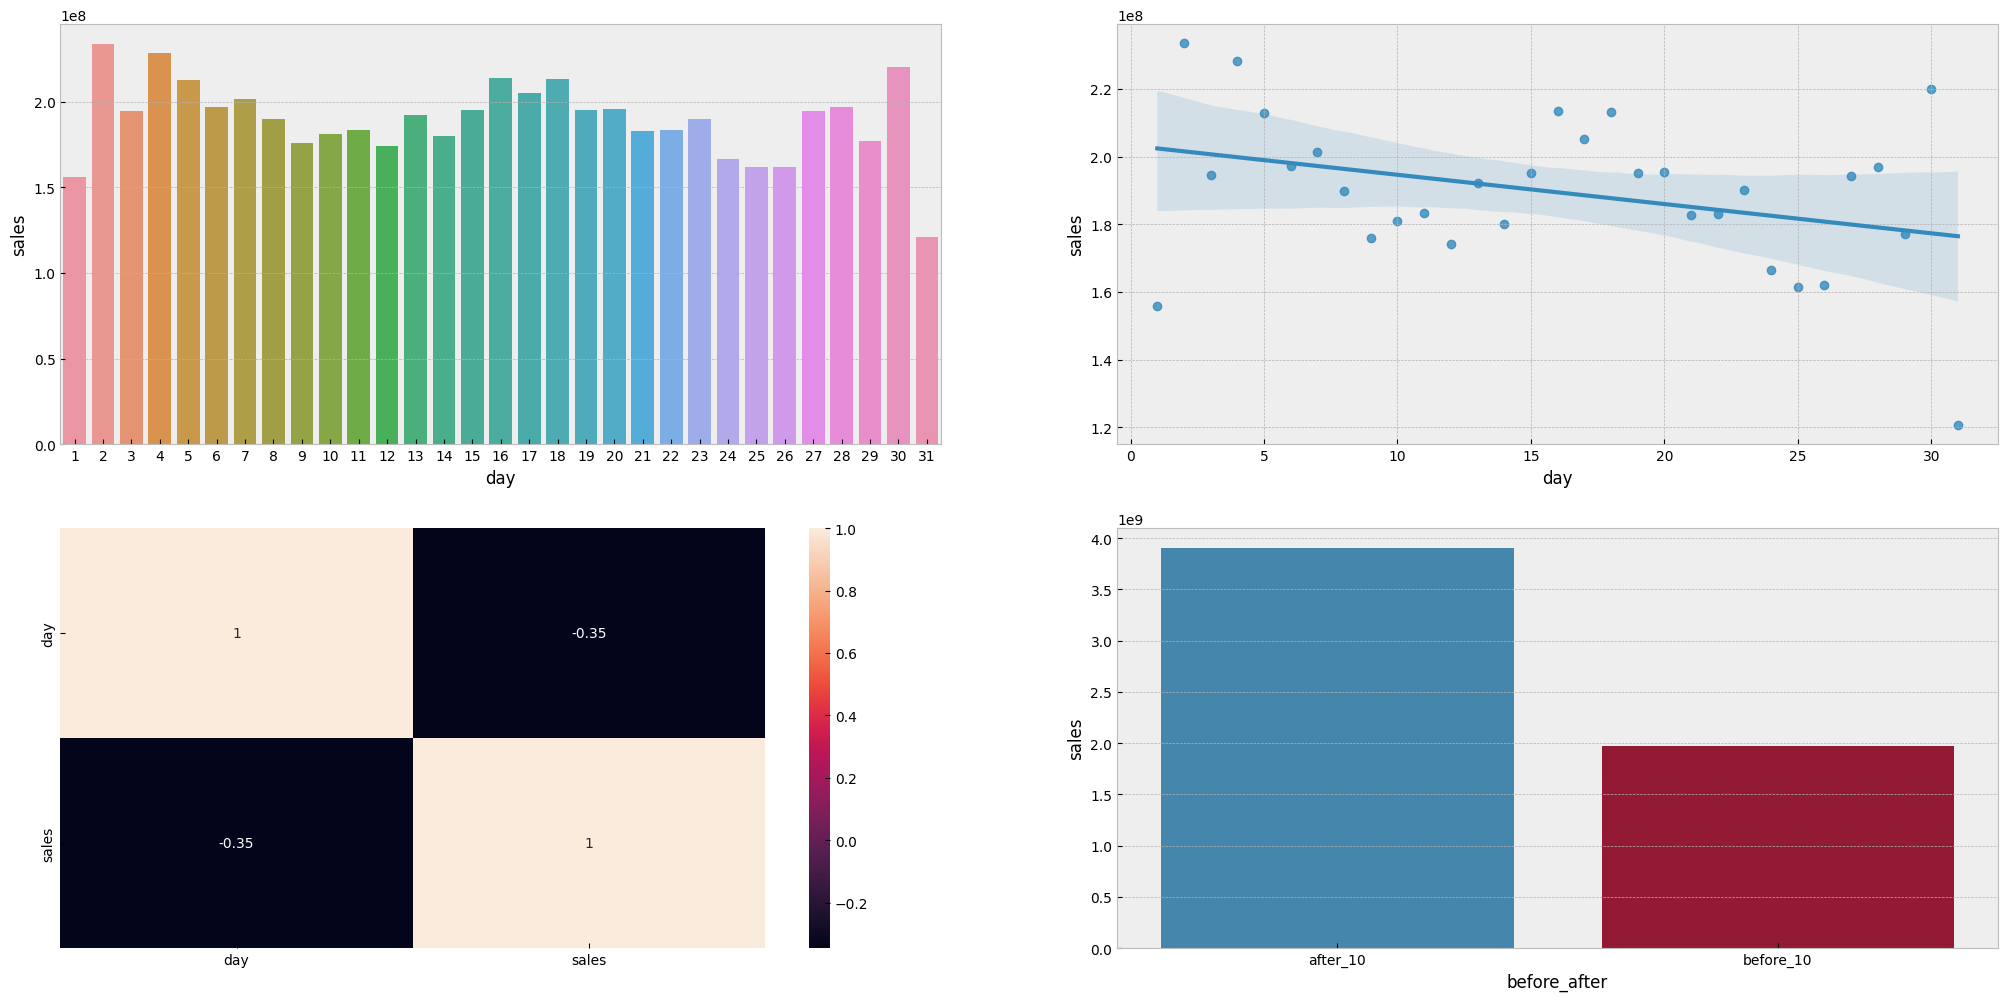

In [43]:
#Hypothesis Analysis
#9. Stores should sell more after the 10th of every month (Yes - Hypothesis Accepted)
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

#Plotting Sales x Day
plt.subplot(2,2,1)
sns.barplot(x='day', y='sales', data=aux1)

#Plotting Sales x Day Regression
plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data=aux1)

#Plotting Sales x Day Correlation
plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

#Plotting Sales x Day Comparison
plt.subplot(2,2,4)
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10' if x<=10 else 'after_10')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()
sns.barplot(x='before_after', y='sales', data=aux2);

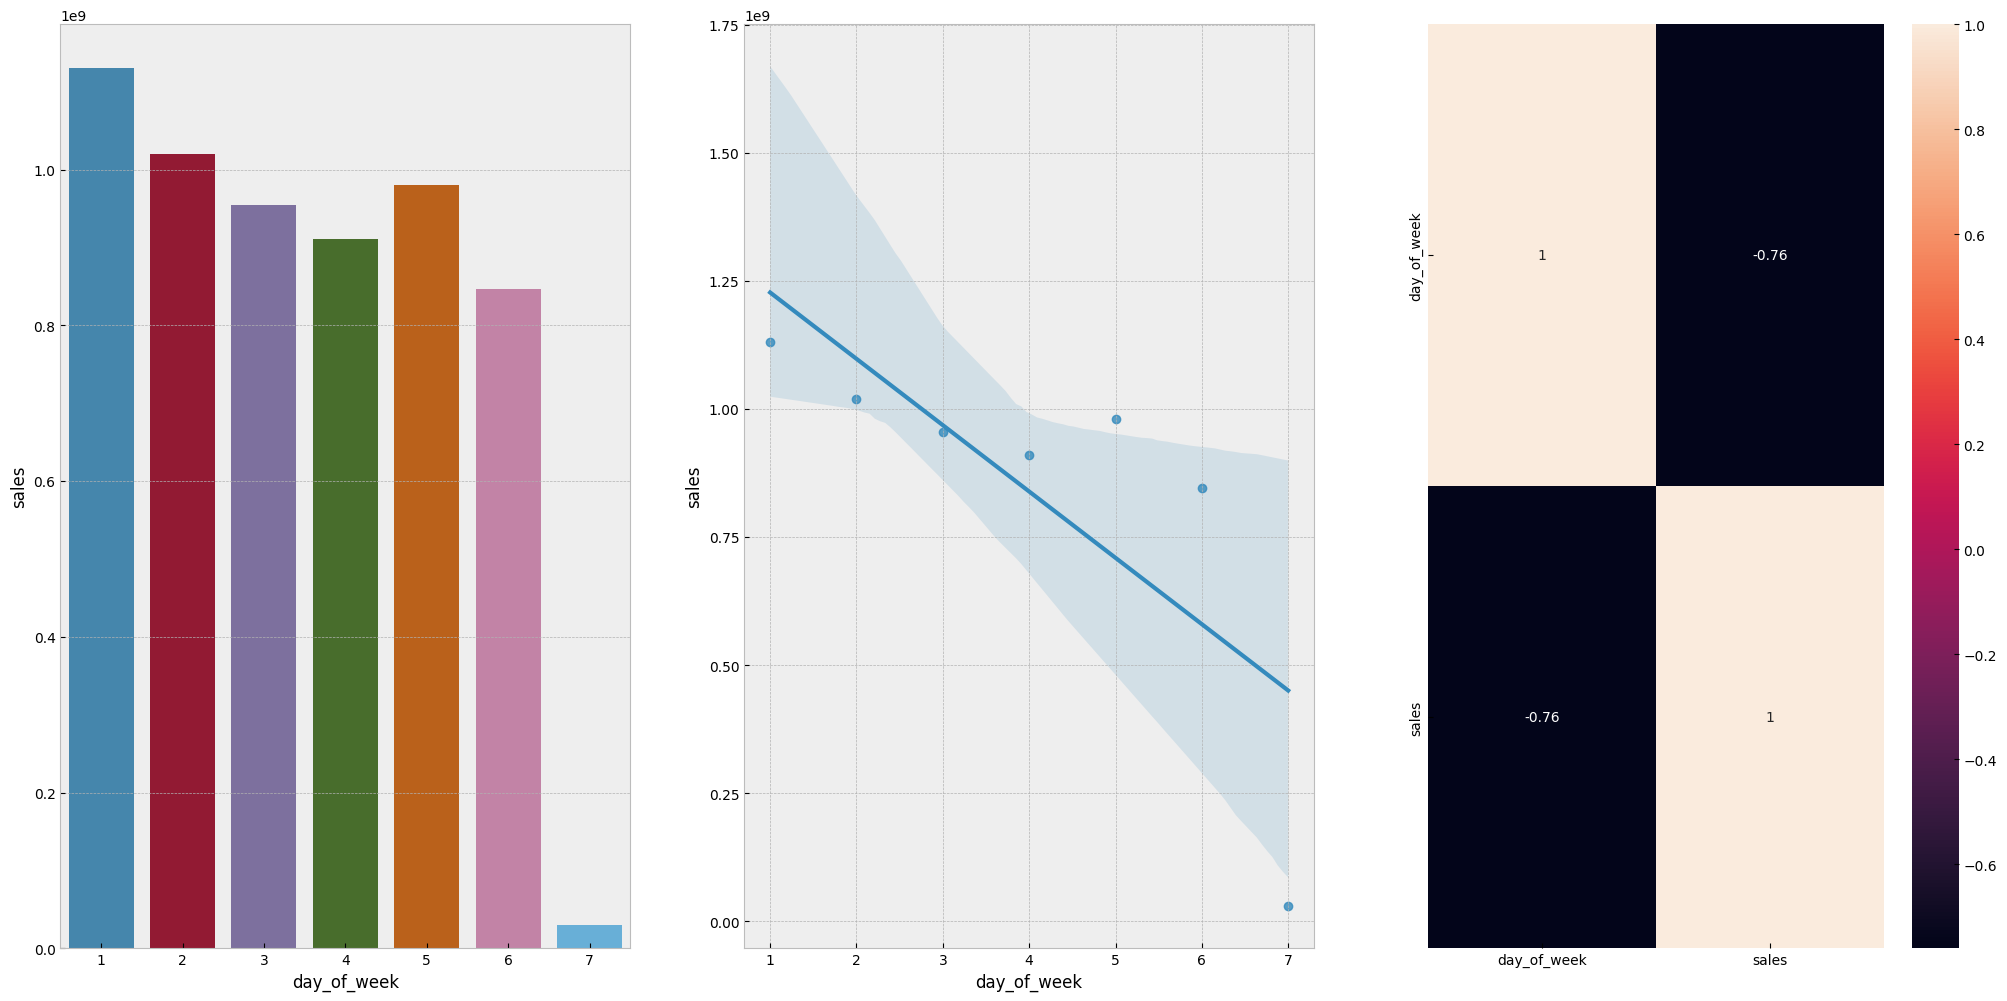

In [44]:
#Hypothesis Analysis
#10. Stores should sell less on weekends (Yes - Hypothesis Accepted)
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

#Plotting Sales x Day of Week
plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y='sales', data=aux1)

#Plotting Sales x Day of Week Regression
plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data=aux1)

#Plotting Sales x Day of Week Correlation
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

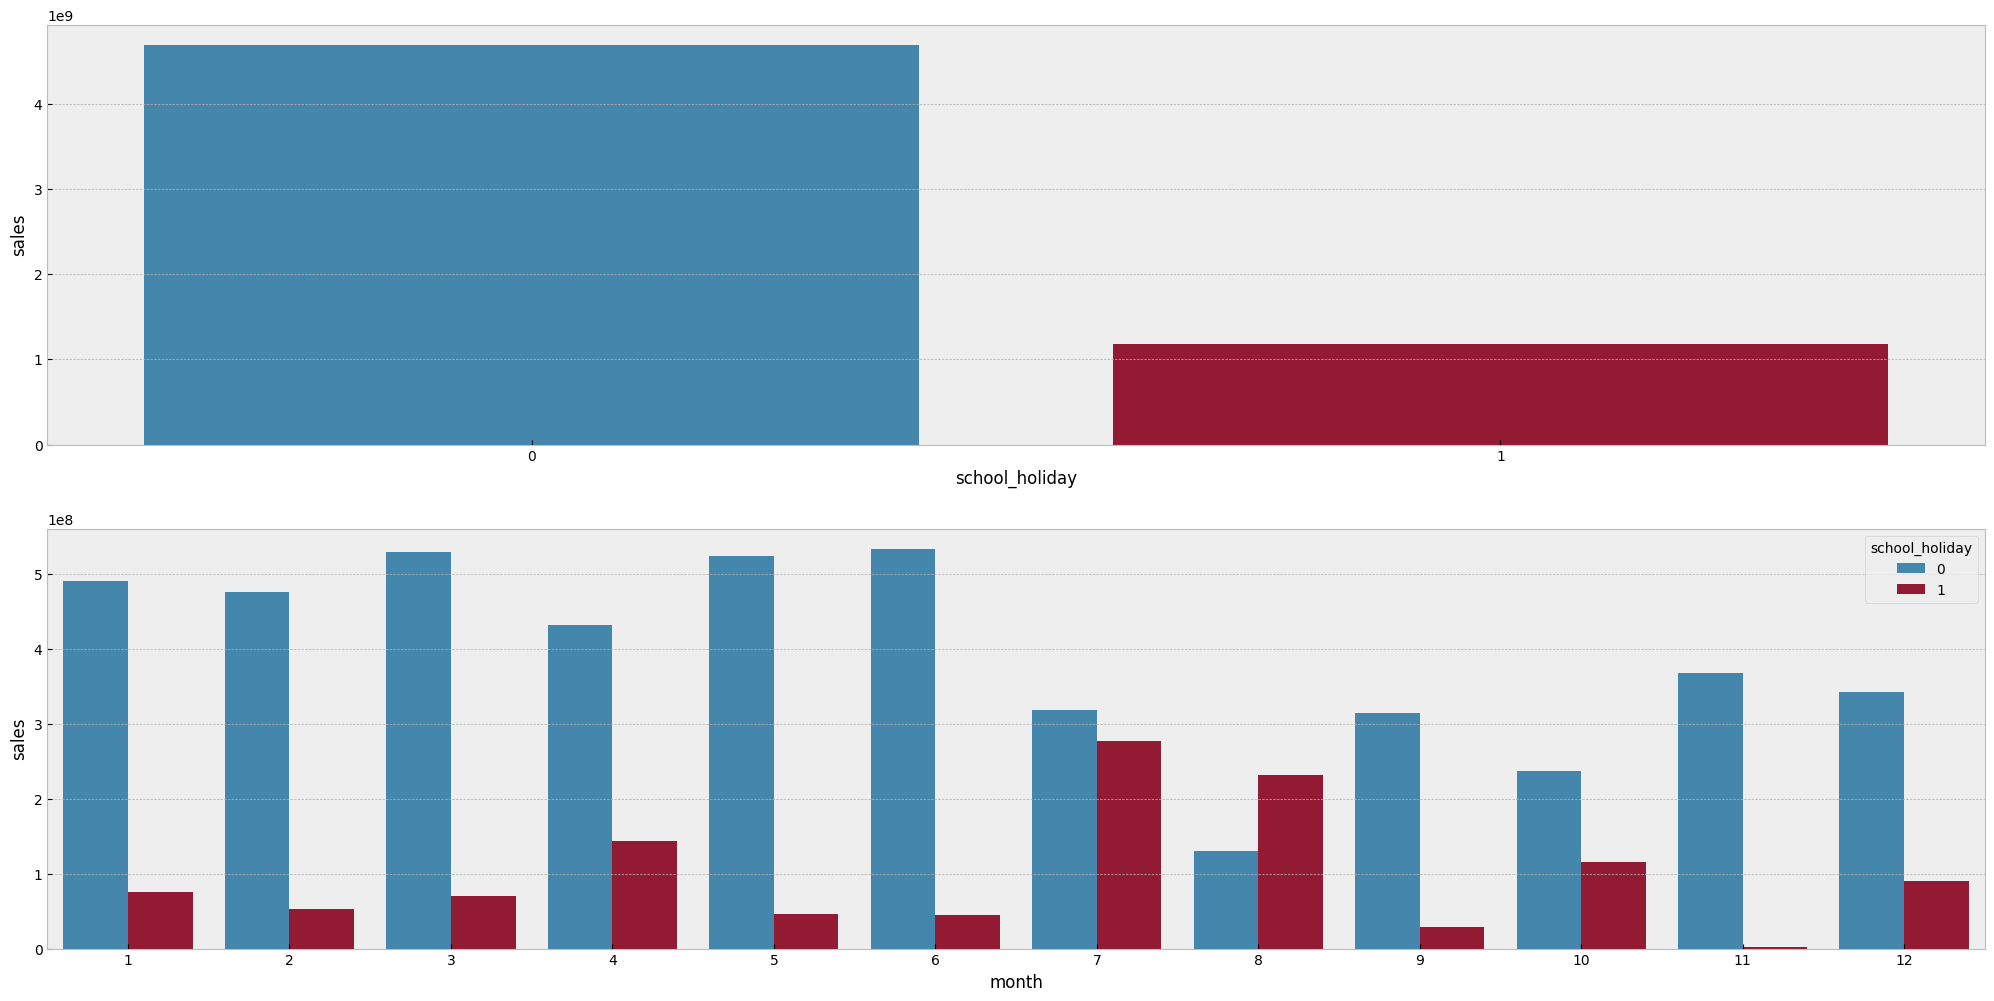

In [45]:
#Hypothesis Analysis
#11. Stores should sell less during school holidays (Yes - Hypothesis Accepted, except for August)
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()

#Plotting Sales x School Holiday
plt.subplot(2,1,1)
sns.barplot(x='school_holiday', y='sales', data=aux1)

#Plotting Sales x School Holiday per Month
plt.subplot(2,1,2)
aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2);

In [46]:
#Hypothesis Summary
tab = [['Hypothesis', 'Conclusion', 'Relevance'],
       ['1', 'False', 'Low'],
       ['2', 'False', 'Medium'],
       ['3', 'False', 'Medium'],
       ['4', 'False', 'Low'],
       ['5', 'False', 'Low'],
       ['6', 'False', 'Medium'],
       ['7', 'False', 'High'],
       ['8', 'False', 'High'],
       ['9', 'True', 'High'],
       ['10', 'True', 'High'],
       ['11', 'True', 'Low'],
       ]
print(tabulate(tab, headers='firstrow'))

  Hypothesis  Conclusion    Relevance
------------  ------------  -----------
           1  False         Low
           2  False         Medium
           3  False         Medium
           4  False         Low
           5  False         Low
           6  False         Medium
           7  False         High
           8  False         High
           9  True          High
          10  True          High
          11  True          Low


### 4.3 Multivariate Analysis

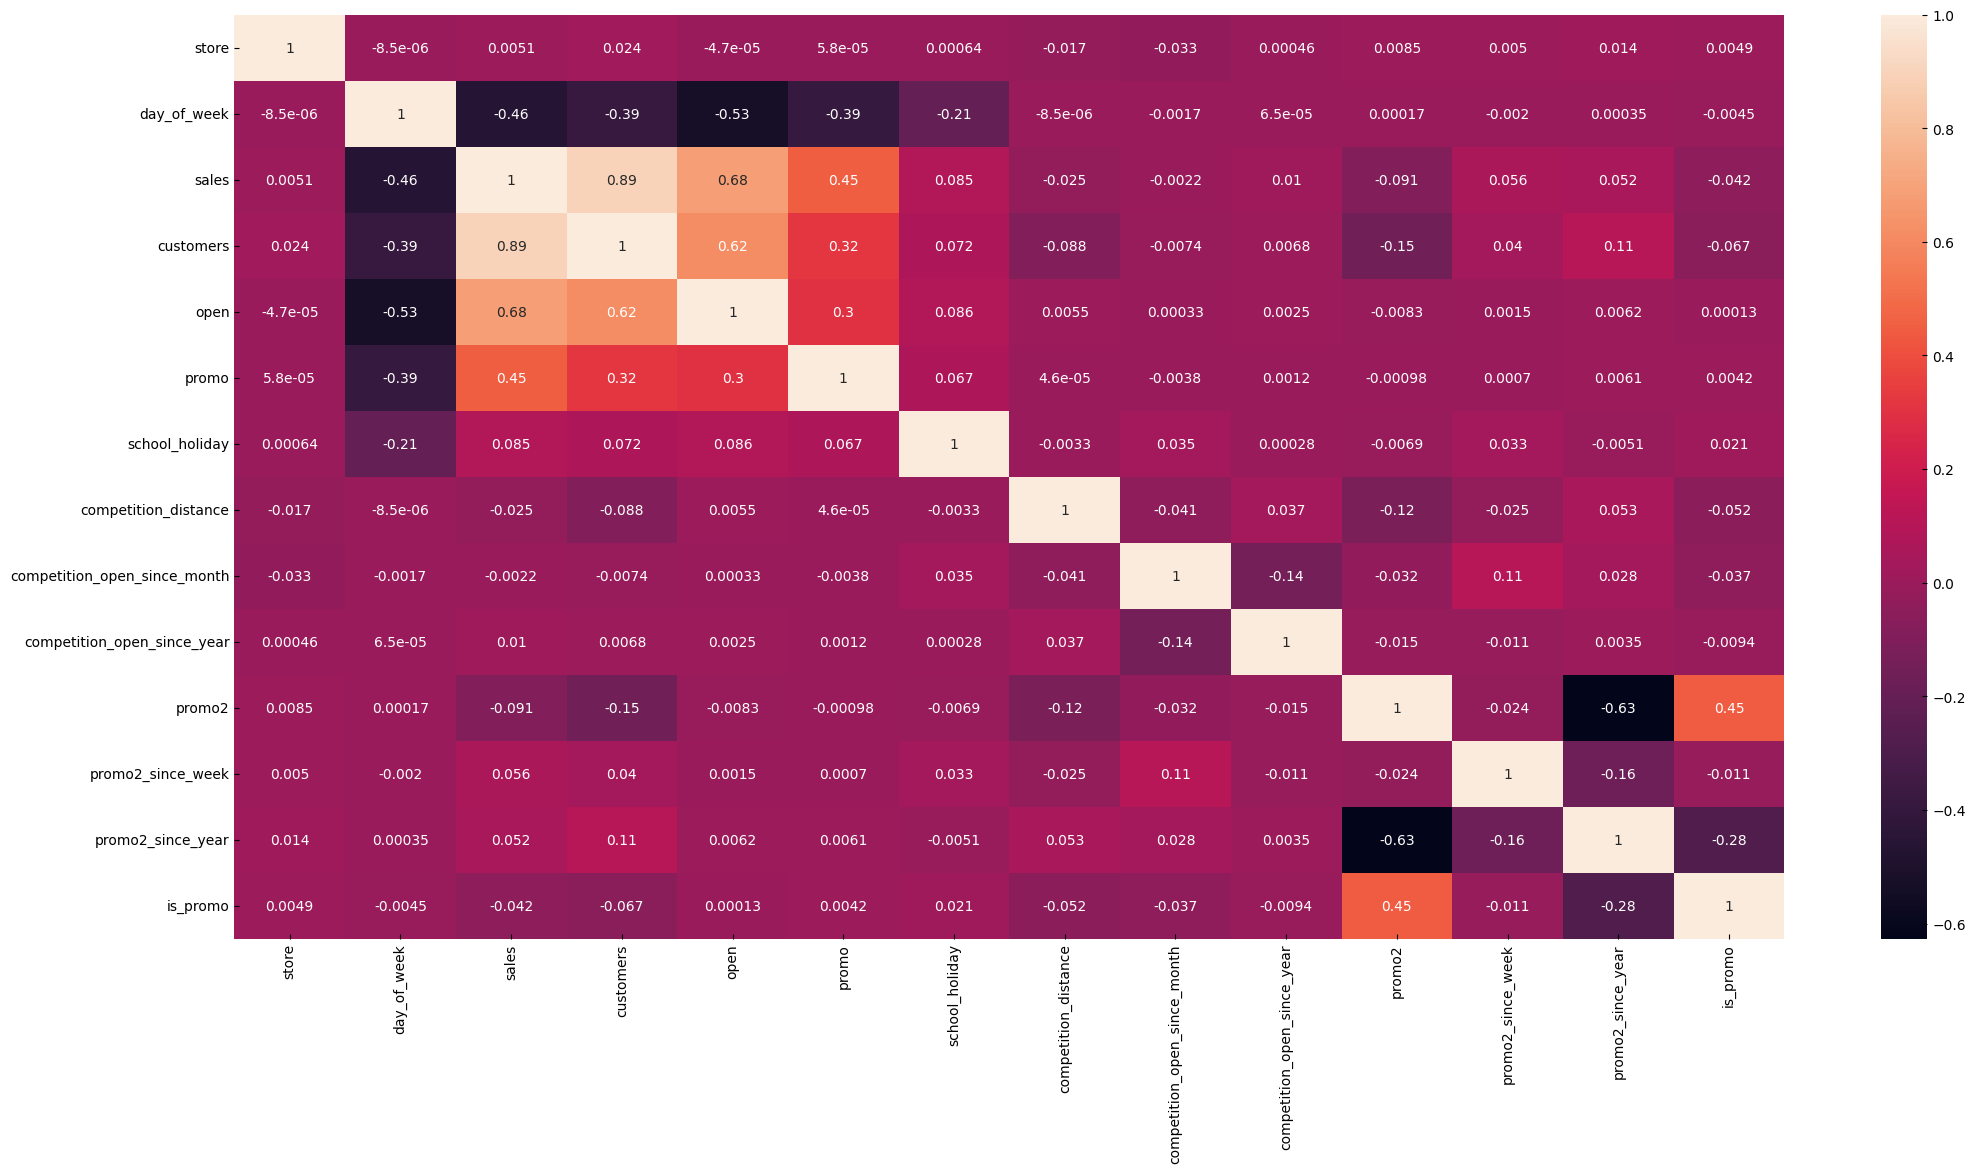

In [47]:
#Numerical Attributes

#Correlation analysis of numerical variables
correlation = num_att.corr(method='pearson')
sns.heatmap(correlation, annot=True);

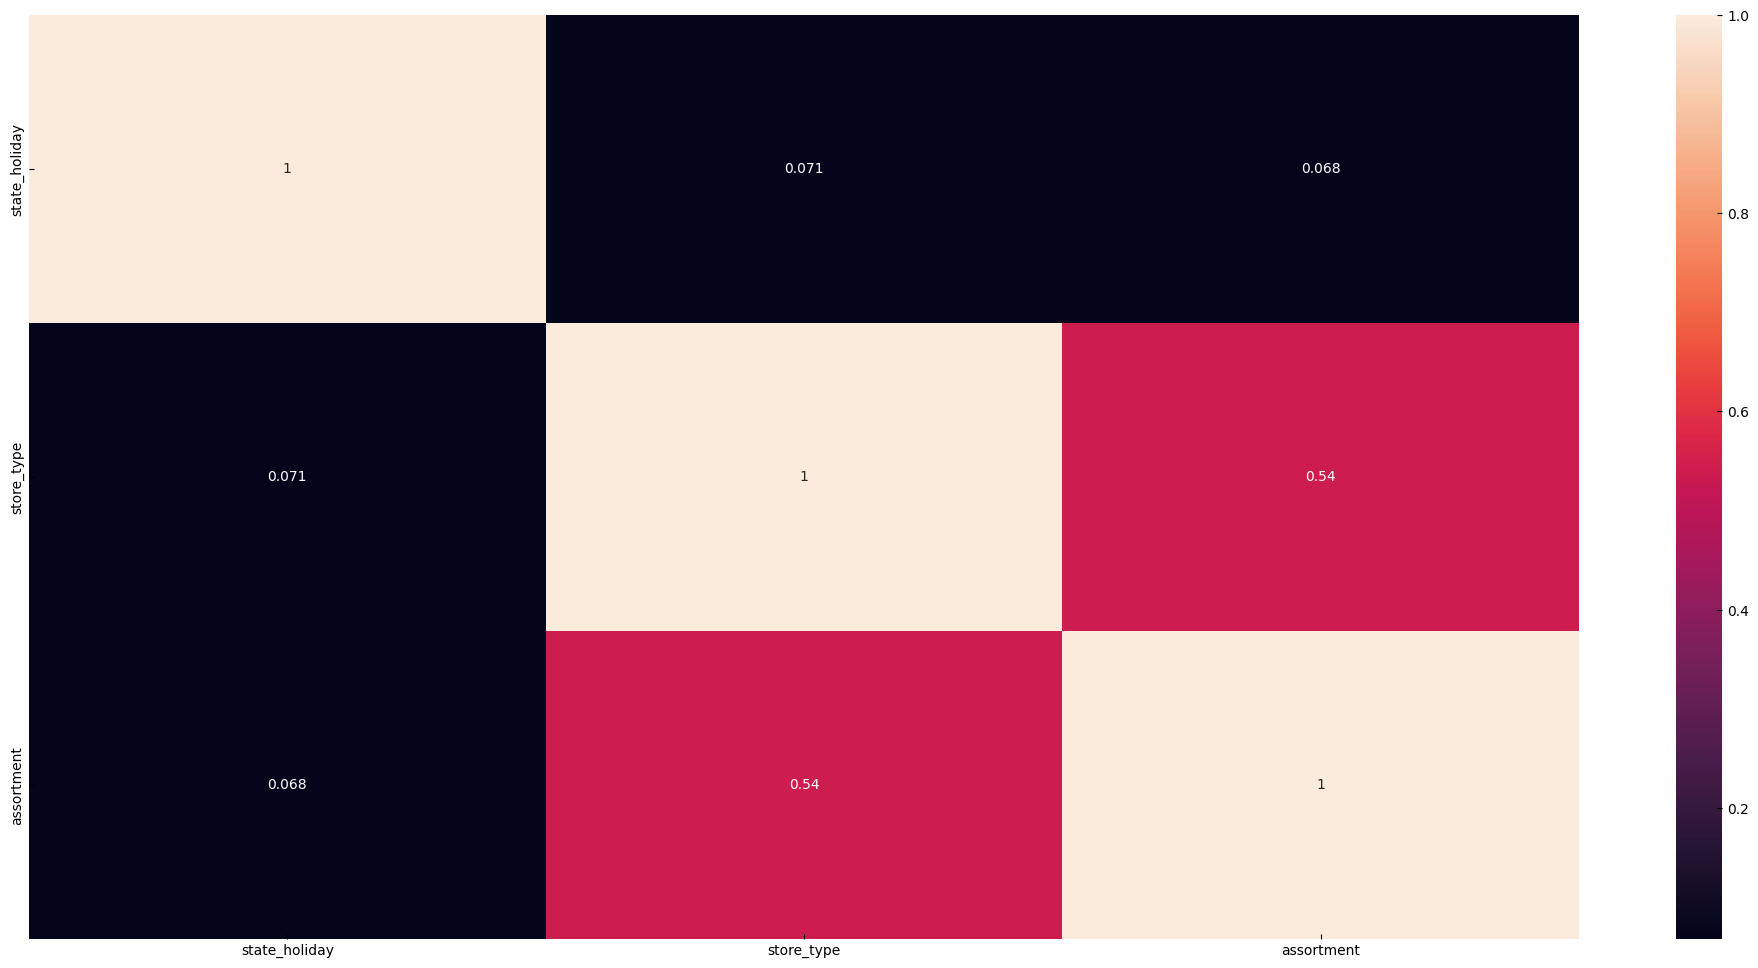

In [48]:
#Categorical Attributes

#Correlation analysis

#Catch only categorical values
c = df4.select_dtypes(include='object')

#Calculate using Cramer V
c1 = cramer_v(c['state_holiday'], c['state_holiday'])
c2 = cramer_v(c['state_holiday'], c['store_type'])
c3 = cramer_v(c['state_holiday'], c['assortment'])

c4 = cramer_v(c['store_type'], c['state_holiday'])
c5 = cramer_v(c['store_type'], c['store_type'])
c6 = cramer_v(c['store_type'], c['assortment'])

c7 = cramer_v(c['assortment'], c['state_holiday'])
c8 = cramer_v(c['assortment'], c['store_type'])
c9 = cramer_v(c['assortment'], c['assortment'])

#Final Dataset
df_c = pd.DataFrame({'state_holiday': [c1, c2, c3],
              'store_type': [c4, c5, c6],
              'assortment': [c7, c8, c9],})

df_c = df_c.set_index(df_c.columns)

#Plot Heatmap for Analysis
sns.heatmap(df_c, annot=True);

# 5.0. Data Preparation

In [49]:
#Dataset backup
df5 = df4.copy()

## 5.1. Normalization

In [50]:
#Evaluation of Univariate Analysis
#Attempt to locate variables with Normal Distribution
#Normalization not performed due to lack of relevant features for this process

## 5.2. Rescaling

In [51]:
#Checking variables to rescale
num = df5.select_dtypes(include=['int64', 'float64'])
num.columns

Index(['store', 'day_of_week', 'sales', 'promo', 'school_holiday',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'month', 'is_promo', 'year', 'day', 'week_of_year',
       'competition_time_month', 'promo_time_week'],
      dtype='object')

In [52]:
#Rescaling on Variables
rs = RobustScaler()
mms = MinMaxScaler()

#competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump(rs, open('parameters/scaler_competition_distance.pkl', 'wb'))

#competition_time_month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump(rs, open('parameters/scaler_competition_time_month.pkl', 'wb'))

#promo_time_week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump(mms, open('parameters/scaler_promo_time_week.pkl', 'wb'))

#year
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump(mms, open('parameters/scaler_year.pkl', 'wb'))

## 5.3. Transformation

In [53]:
#Encoding
#One Hot Encoding - state_holiday
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

#Label Encoding - store_type
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open('parameters/enc_store_type.pkl', 'wb'))

#Ordinal Encoding - assortment
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

In [54]:
#Transformation - Response Variable
df5['sales'] = np.log1p(df5['sales'])

In [55]:
#Transformation - Ciclical Variables (Nature Transformation)
#month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*(2*np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(2*np.pi/12)))

#day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*(2*np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*(2*np.pi/30)))

#week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x*(2*np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x*(2*np.pi/52)))

#day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2*np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2*np.pi/7)))

# 6.0. Feature Selection

In [56]:
#Dataset backup
df6 = df5.copy()

In [57]:
#Checking columns
df6.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'school_holiday',
       'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'month', 'is_promo', 'year',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week',
       'state_holiday_christmas', 'state_holiday_easter_holiday',
       'state_holiday_public_holiday', 'state_holiday_regular_day',
       'month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin',
       'week_of_year_cos', 'day_of_week_sin', 'day_of_week_cos'],
      dtype='object')

In [58]:
#Selecting features
cols_drop = ['month', 'day', 'day_of_week', 'week_of_year', 'year_week', 'competition_since', 'promo_since']
df6 = df6.drop(cols_drop, axis=1)

## 6.1. Split Dataframe into Training and Test Dataset

In [59]:
#Selection of specific date to split data - Considering the last 6 weeks of the dataset
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [60]:
#Train Dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

#Test Dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Training Min. Date: {}'.format(X_train['date'].min()))
print('Training Max. Date: {}'.format(X_train['date'].max()))

print('\nTest Min. Date: {}'.format(X_test['date'].min()))
print('Test Max. Date: {}'.format(X_test['date'].max()))

Training Min. Date: 2013-01-01 00:00:00
Training Max. Date: 2015-06-18 00:00:00

Test Min. Date: 2015-06-19 00:00:00
Test Max. Date: 2015-07-31 00:00:00


## 6.2. Boruta as Feature Selector

In [61]:
##Define Training and Test datasets for Boruta
#X_train_n = X_train.drop(['date', 'sales'], axis=1).values
#y_train_n = y_train.values.ravel()
#
##Define RandomForestRegressor
#rf = RandomForestRegressor(n_jobs=-1)
#
##Define Boruta
#boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)
#cols_sel = boruta.support_.tolist()
#
##Best features
#X_train_fs = X_train.drop(['date', 'sales'], axis=1)
#cols_sel_boruta = X_train_fs.iloc[:, cols_sel].columns.tolist()
#
##Fetures not selected by Boruta
#cols_not_sel_boruta = list(np.setdiff1d(X_train_fs.columns, cols_sel_boruta))
##Checking columns selected by Boruta
#cols_sel_boruta
#
##Checking columns not selected by Boruta
#cols_not_sel_boruta

6.2.1 Columns Selected by Boruta

'store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_cos',
 'day_of_week_sin',
 'day_of_week_cos'

6.2.2 Columns Not Selected by Boruta

'is_promo',
 'month_sin',
 'school_holiday',
 'state_holiday_christmas',
 'state_holiday_easter_holiday',
 'state_holiday_public_holiday',
 'state_holiday_regular_day',
 'week_of_year_sin',
 'year'

## 6.3. Manual Feature Selection

In [62]:
#Manual selected columns after analysis
cols_sel_manual = ['store',
                    'promo',
                    'store_type',
                    'assortment',
                    'competition_distance',
                    'competition_open_since_month',
                    'competition_open_since_year',
                    'promo2',
                    'promo2_since_week',
                    'promo2_since_year',
                    'competition_time_month',
                    'promo_time_week',
                    'month_sin',
                    'month_cos',
                    'day_sin',
                    'day_cos',
                    'week_of_year_sin',
                    'week_of_year_cos',
                    'day_of_week_sin',
                    'day_of_week_cos']

#Columns to add
ft_add = ['date', 'sales']

#Adding Final Features
cols_sel_manual_full = cols_sel_manual.copy()
cols_sel_manual_full.extend(ft_add)

In [63]:
#Checking Columns Selected
cols_sel_manual_full

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos',
 'day_of_week_sin',
 'day_of_week_cos',
 'date',
 'sales']

# 7.0. Machine Learning Modelling

In [64]:
#Define Train/Test
x_train = X_train[cols_sel_manual]
x_test = X_test[cols_sel_manual]

##Time Series data preparation
x_training = X_train[cols_sel_manual_full]

## 7.1. Average Model

In [65]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

#Prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

##Performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.80,0.46,1835.14


## 7.2. Linear Regression Model

In [66]:
#Model
lr = LinearRegression().fit(x_train, y_train)

#Prediction
yhat_lr = lr.predict(x_test)

#Performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1868.42,0.29,2671.00


### 7.2.1 Linear Regression - Cross Validation

In [ ]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose=False)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.91+/-295.72,0.3+/-0.02,2951.27+/-468.66


## 7.3. Linear Regression Regularized Model (Lasso)

In [67]:
#Model
lrr = Lasso(alpha=0.01).fit(x_train, y_train)

#Predicition
yhat_lrr = lrr.predict(x_test)

#Performance
lrr_result = ml_error('Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Lasso,1892.35,0.29,2744.36


### 7.3.1 Lasso - Cross Validation

In [ ]:
lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr, verbose=False)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.39+/-341.57,0.29+/-0.01,3057.07+/-504.39


## 7.4. Random Forest Regressor

In [68]:
#Model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)

#Prediction
yhat_rf = rf.predict(x_test)

#Performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.69,0.10,1010.61


### 7.4.1 Random Forest Regressor - Cross Validation

In [ ]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose=False)
rf_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,837.97+/-218.4,0.12+/-0.02,1256.45+/-318.73


## 7.5. XGBoost Regressor

In [69]:
#Model
xgboost = xgb.XGBRegressor(objective='reg:squarederror',
                           n_estimators=100,
                           eta=0.01,
                           max_depth=10,
                           subsample=0.7).fit(x_train, y_train)

#Prediciton
yhat_xgb = xgboost.predict(x_test)

#Performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6683.67,0.95,7330.82


### 7.5.1 XGBoost Regressor - Cross Validation

In [ ]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', xgboost, verbose=False)
xgb_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,7047.99+/-587.65,0.95+/-0.0,7714.05+/-688.72


## 7.6. Compare Model's Performance

### 7.6.1 Single Performance

In [70]:
model_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
model_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.69,0.10,1010.61
0,Average Model,1354.80,0.46,1835.14
0,Linear Regression,1868.42,0.29,2671.00
0,Lasso,1892.35,0.29,2744.36
0,XGBoost Regressor,6683.67,0.95,7330.82


### 7.6.2 Real Performance

In [ ]:
model_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
model_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.91+/-295.72,0.3+/-0.02,2951.27+/-468.66
0,Lasso,2116.39+/-341.57,0.29+/-0.01,3057.07+/-504.39
0,Random Forest Regressor,837.97+/-218.4,0.12+/-0.02,1256.45+/-318.73
0,XGBoost Regressor,7047.99+/-587.65,0.95+/-0.0,7714.05+/-688.72


# 8.0. Hyperparameter Fine Tunning

## 8.1. Random Search

In [ ]:
#Define parameters
param = {'n_estimators': [500, 3000],
         'eta': [0.01, 0.03],
         'max_depth': [3, 5],
         'subsample': [0.5, 0.7],
         'min_child_weight': [3, 5]}

#Define max number of evaluations
MAX_EVAL = 2

In [ ]:
#Random Search implementation
final_result = pd.DataFrame()

for i in range (MAX_EVAL):
    #Randomly choose of parameters
    hp = {k: random.sample(v, 1)[0] for k , v in param.items()}
    print(hp)

    #Model
    xgboost = xgb.XGBRegressor(objective='reg:squarederror',
                               n_estimators=hp['n_estimators'],
                               eta=hp['eta'],
                               max_depth=hp['max_depth'],
                               subsample=hp['subsample'],
                               min_child_weight=hp['min_child_weight'])
    
    #Performance
    result = cross_validation(x_training, 5, 'XGBoost Regressor', xgboost, verbose=False)
    final_result = pd.concat([final_result, result])

final_result

## 8.2. Final Model

In [71]:
#Define tuned parameters
param_tuned = {'n_estimators': 3000,
               'eta': 0.03,
               'max_depth': 5,
               'subsample': 0.7,
               'min_child_weight': 3
               }

In [72]:
#Model Tuned
xgboost_tuned = xgb.XGBRegressor(objective='reg:squarederror',
                                 n_estimators=param_tuned['n_estimators'],
                                 eta=param_tuned['eta'],
                                 max_depth=param_tuned['max_depth'],
                                 subsample=param_tuned['subsample'],
                                 min_child_weight=param_tuned['min_child_weight']
                                 ).fit(x_train, y_train)

#Prediction
yhat_xgb_tuned = xgboost_tuned.predict(x_test)

#Performance
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,760.98,0.11,1090.62


In [ ]:
##Export model for future use
#pickle.dump(xgboost_tuned, open('models/xgb_model.pkl', 'wb'))

In [ ]:
##Import model
#model = open('models/xgb_model.pkl', 'rb')
#xgboost_tuned = pickle.load(model)
#
##Prediction
#yhat_xgb_tuned = xgboost_tuned.predict(x_test)
#
##Performance
#xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
#xgb_result_tuned

In [73]:
#Analysis of MPE
mpe = mean_percentage_error(np.expm1(y_test), np.expm1(yhat_xgb_tuned))
print('MPE: {:.2f}%'.format(mpe*100))

#Analysis of MAPE
mape = mean_absolute_perc_error(np.expm1(y_test), np.expm1(yhat_xgb_tuned))
print('MAPE: {:.2f}%'.format(mape*100))

MPE: -1.91%
MAPE: 11.46%


# 9.0. Business Results

In [74]:
#Dataset backup
df9 = X_test[cols_sel_manual_full]

In [75]:
#Rescaling data
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

## 9.1. Business Performance

In [76]:
#Sum of Predictions
df9_1 = df9[['store', 'sales', 'predictions']].groupby('store').sum().reset_index()

#MAE, MAPE and RMSE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_perc_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAPE'})
df9_aux3 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: np.sqrt(mean_absolute_perc_error(x['sales'], x['predictions']))).reset_index().rename(columns={0:'RMSE'})

#Merge
df9_aux4 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df9_aux5 = pd.merge(df9_aux4, df9_aux3, how='inner', on='store')
df9_2 = pd.merge(df9_1, df9_aux5, how='inner', on='store')

#Scenarios
df9_2['worst_scenario'] = df9_2['predictions'] - df9_2['MAE']
df9_2['best_scenario'] = df9_2['predictions'] + df9_2['MAE']
df9_2['dif'] = df9_2['predictions'] - df9_2['sales']
df9_2['dif_%'] = (df9_2['predictions'] / df9_2['sales'])-1

#Order columns
df9_2 = df9_2[['store', 'sales', 'predictions', 'dif', 'dif_%', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE', 'RMSE']]

#Check Dataset
df9_2

,store,sales,predictions,dif,dif_%,worst_scenario,best_scenario,MAE,MAPE,RMSE
0,1,162320.00,169443.64,7123.64,0.04,169126.32,169760.97,317.32,0.07,0.27
1,2,182936.00,179460.02,-3475.98,-0.02,179017.01,179903.02,443.00,0.09,0.30
2,3,254190.00,270797.22,16607.22,0.07,270078.39,271516.05,718.83,0.10,0.31
3,4,369378.00,353223.06,-16154.94,-0.04,352472.37,353973.76,750.70,0.07,0.27
4,5,166905.00,167037.98,132.98,0.00,166713.65,167362.32,324.33,0.07,0.27
...,...,...,...,...,...,...,...,...,...,...
1110,1111,173854.00,184384.73,10530.73,0.06,183705.05,185064.42,679.68,0.15,0.39
1111,1112,319237.00,341137.84,21900.84,0.07,340131.61,342144.08,1006.24,0.12,0.35
1112,1113,243427.00,249598.69,6171.69,0.03,249041.63,250155.74,557.06,0.09,0.30
1113,1114,842724.00,788804.06,-53919.94,-0.06,786850.01,790758.12,1954.05,0.08,0.29


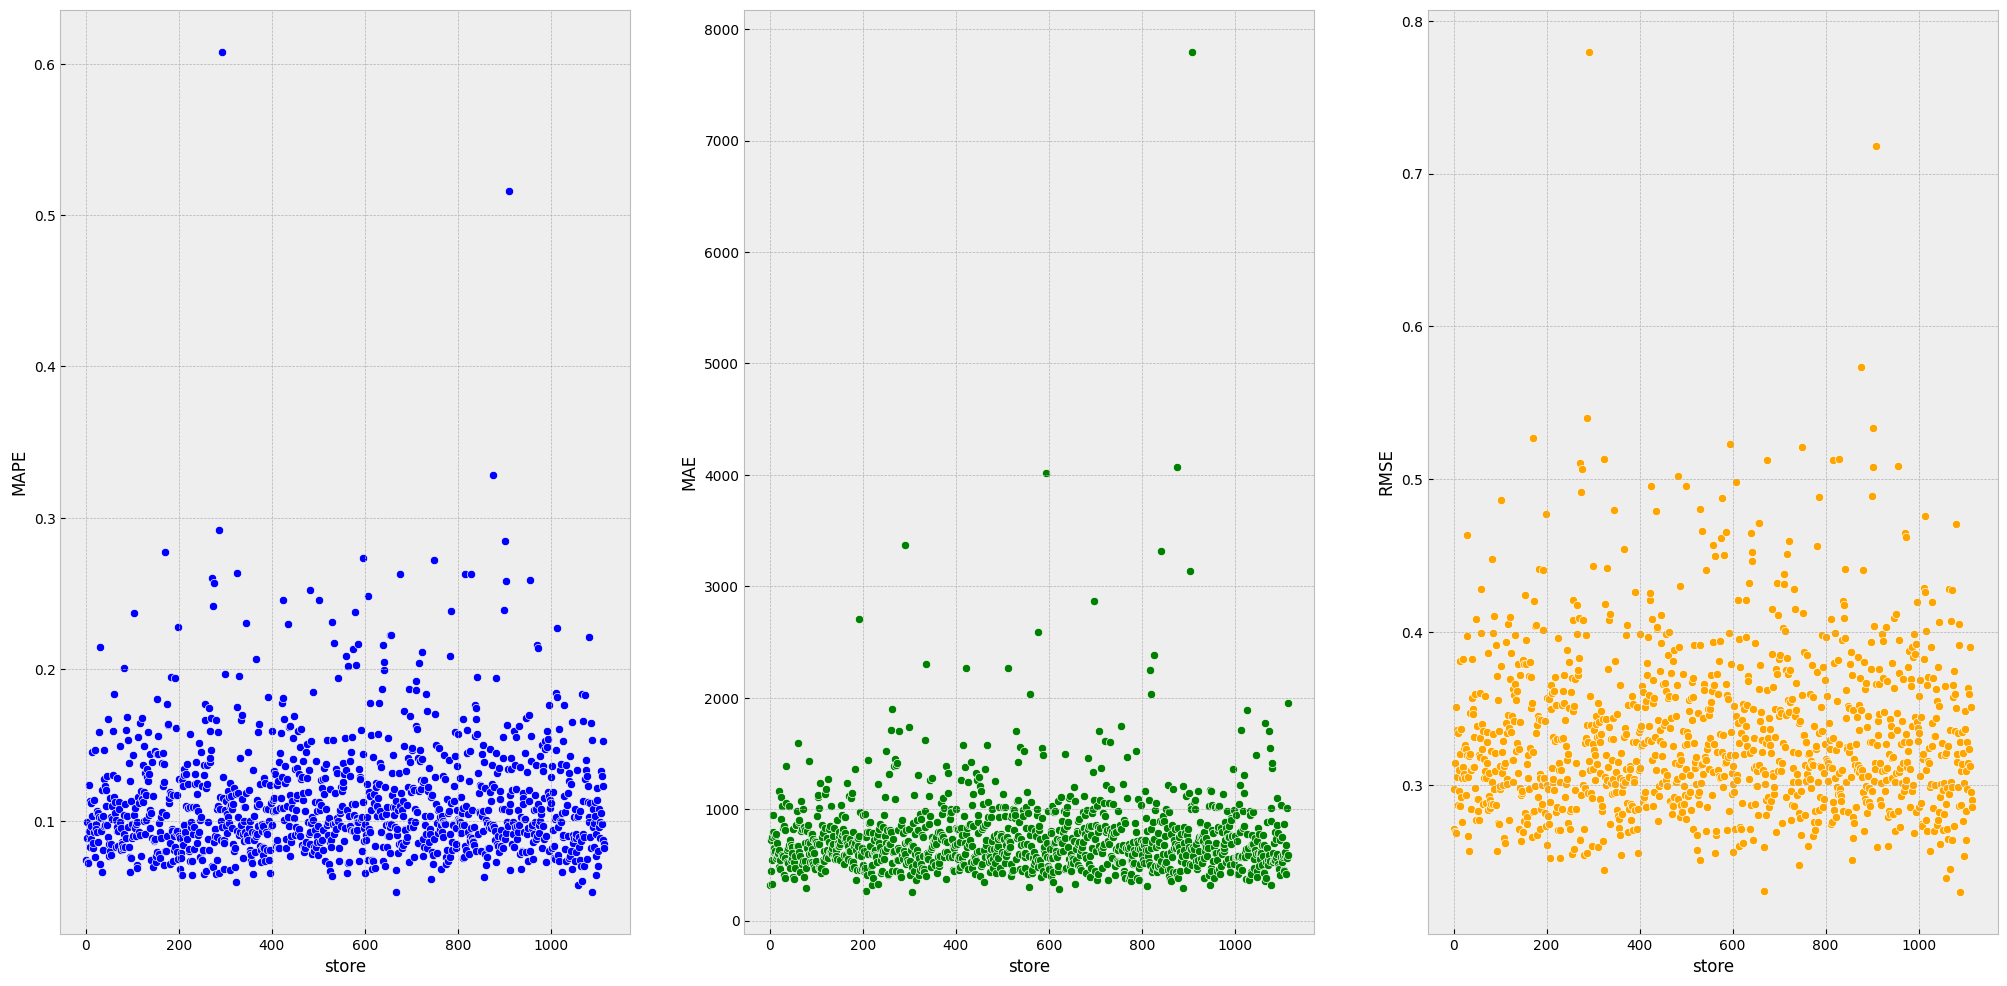

In [77]:
#Visual Check of Dataset
plt.subplot(1,3,1)
sns.scatterplot(x='store', y='MAPE', data=df9_2, color='blue')

plt.subplot(1,3,2)
sns.scatterplot(x='store', y='MAE', data=df9_2, color='green')

plt.subplot(1,3,3)
sns.scatterplot(x='store', y='RMSE', data=df9_2, color='orange');

## 9.2. Total Performance

In [78]:
#Check performance with sales data
df9_3 = df9_2[['sales', 'predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index':'Scenario', 0:'Values'})

df9_3['Values'] = df9_3['Values'].map('${:,.2f}'.format)
df9_3

,Scenario,Values
0,sales,"$289,571,750.00"
1,predictions,"$287,098,048.00"
2,worst_scenario,"$286,246,349.96"
3,best_scenario,"$287,949,719.43"


In [79]:
#Check performance without sales data
df9_4 = df9_2[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index':'Scenario', 0:'Values'})

df9_4['Values'] = df9_4['Values'].map('${:,.2f}'.format)
df9_4

,Scenario,Values
0,predictions,"$287,098,048.00"
1,worst_scenario,"$286,246,349.96"
2,best_scenario,"$287,949,719.43"


## 9.3. Machine Learning Performance

In [80]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

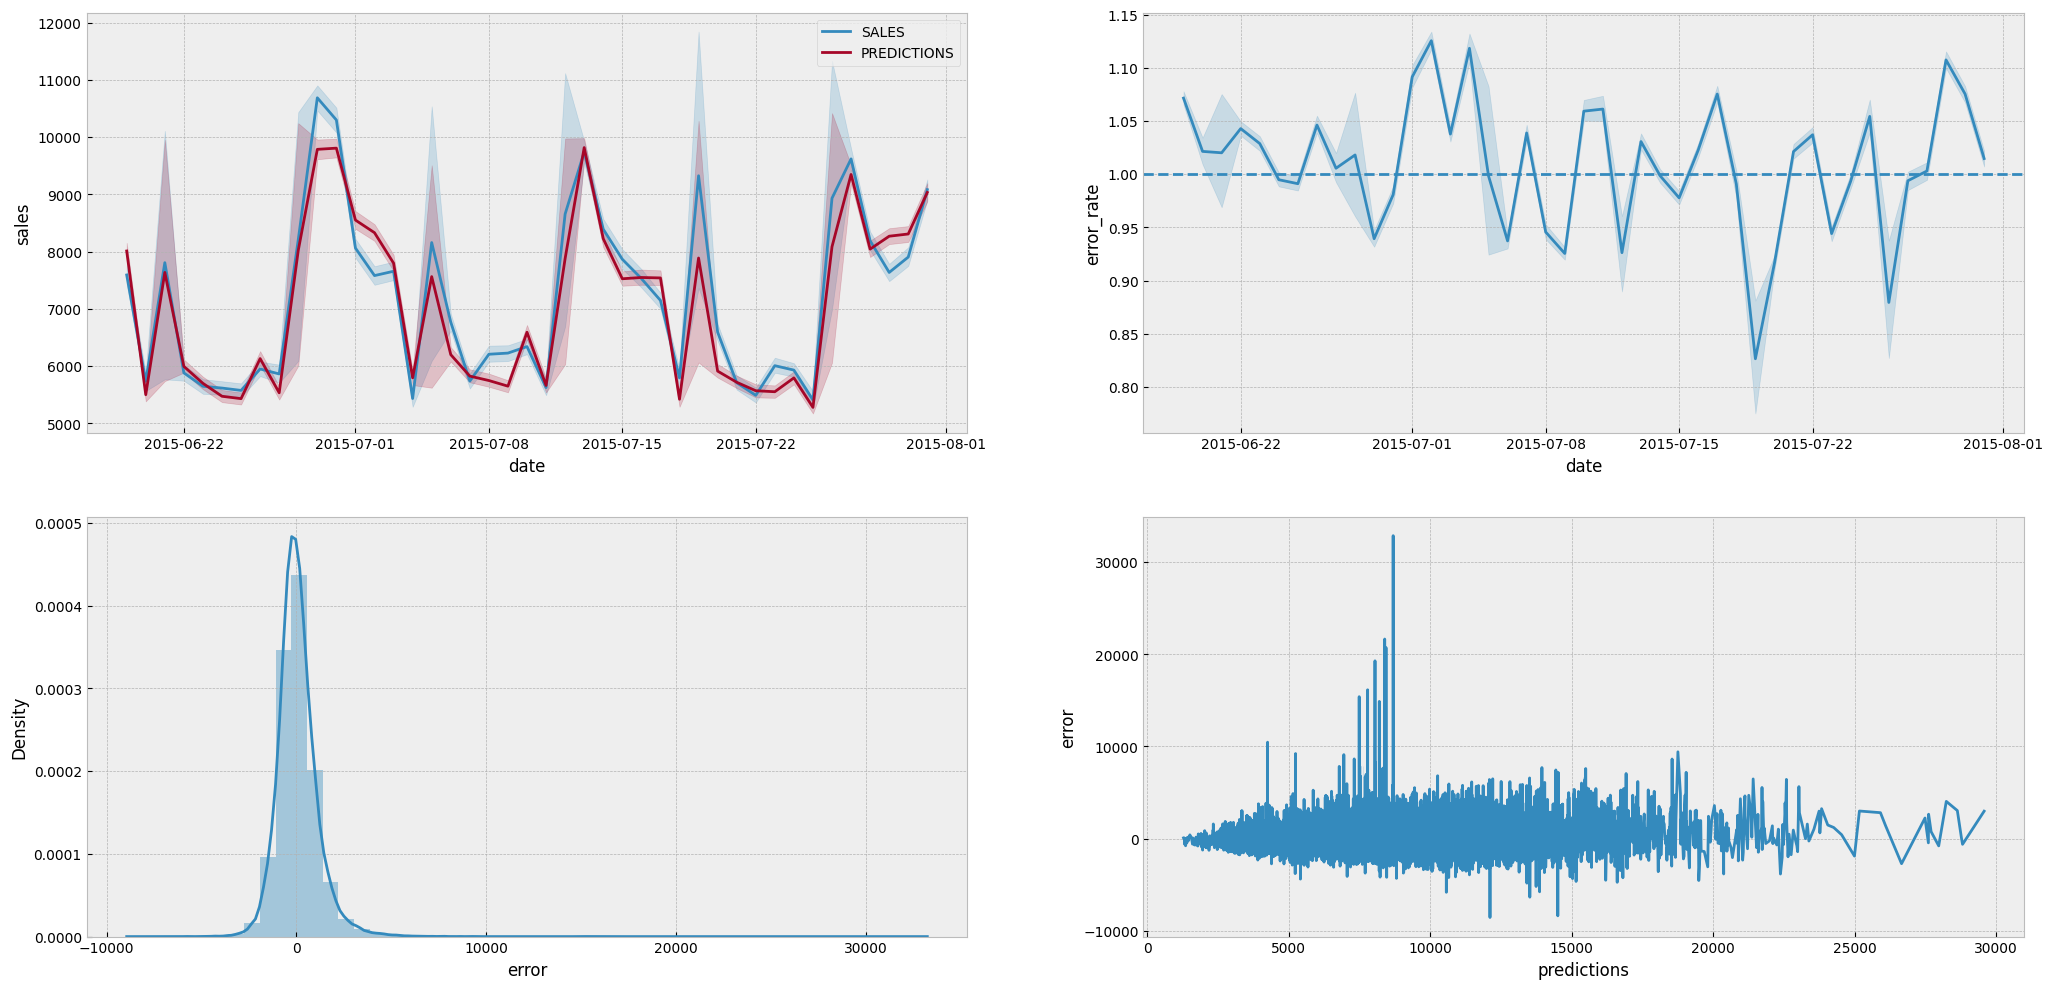

In [81]:
plt.subplot(2,2,1)
sns.lineplot(x='date', y='sales', data=df9, label='SALES')
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICTIONS')

plt.subplot(2,2,2)
sns.lineplot(x='date', y='error_rate', data=df9)
plt.axhline(1, linestyle='--')

plt.subplot(2,2,3)
sns.distplot(df9['error'])

plt.subplot(2,2,4)
sns.lineplot(x='predictions', y='error', data=df9);

## 9.4. Export Data

In [82]:
#Export main dataset analysis
#Define columns to export data
df_exp = df9_2[['store', 'predictions', 'worst_scenario', 'best_scenario']]

#Adjust data types
df_exp['worst_scenario'] = df_exp['worst_scenario'].astype('float32')
df_exp['best_scenario'] = df_exp['best_scenario'].astype('float32')
print(df_exp.dtypes)

#Export data
df_exp.to_csv('data/sales_predict.csv', index=False)

store               int64
predictions       float32
worst_scenario    float32
best_scenario     float32
dtype: object


In [83]:
#Export full dataset analysis
#Adjust data types
df9_2['sales'] = df9_2['sales'].astype('float32')
df9_2['dif'] = df9_2['dif'].astype('float32')
df9_2['dif_%'] = df9_2['dif_%'].astype('float32')
df9_2['worst_scenario'] = df9_2['worst_scenario'].astype('float32')
df9_2['best_scenario'] = df9_2['best_scenario'].astype('float32')
df9_2['MAE'] = df9_2['MAE'].astype('float32')
df9_2['MAPE'] = df9_2['MAPE'].astype('float32')
df9_exp2 = df9_2
print(df9_exp2.dtypes)

#Export data
df9_exp2.to_csv('data/sales_predict_full.csv', index=False)

#Show dataset
df9_exp2

store               int64
sales             float32
predictions       float32
dif               float32
dif_%             float32
worst_scenario    float32
best_scenario     float32
MAE               float32
MAPE              float32
RMSE              float64
dtype: object


,store,sales,predictions,dif,dif_%,worst_scenario,best_scenario,MAE,MAPE,RMSE
0,1,162320.00,169443.64,7123.64,0.04,169126.31,169760.97,317.32,0.07,0.27
1,2,182936.00,179460.02,-3475.98,-0.02,179017.02,179903.02,443.00,0.09,0.30
2,3,254190.00,270797.22,16607.22,0.07,270078.38,271516.06,718.83,0.10,0.31
3,4,369378.00,353223.06,-16154.94,-0.04,352472.38,353973.75,750.70,0.07,0.27
4,5,166905.00,167037.98,132.98,0.00,166713.66,167362.31,324.33,0.07,0.27
...,...,...,...,...,...,...,...,...,...,...
1110,1111,173854.00,184384.73,10530.73,0.06,183705.05,185064.42,679.68,0.15,0.39
1111,1112,319237.00,341137.84,21900.84,0.07,340131.59,342144.09,1006.24,0.12,0.35
1112,1113,243427.00,249598.69,6171.69,0.03,249041.62,250155.75,557.06,0.09,0.30
1113,1114,842724.00,788804.06,-53919.94,-0.06,786850.00,790758.12,1954.05,0.08,0.29


In [84]:
#Export dataset with date values
#Define columns to export data
df9_exp3 = df9[['store', 'date', 'predictions']]

#Check data types
print(df9_exp3.dtypes)

#Export data
df9_exp3.to_csv('data/sales_predict_date.csv', index=False)

#Show dataset
df9_exp3

store                   int64
date           datetime64[ns]
predictions           float32
dtype: object


,store,date,predictions
0,1,2015-07-31,5818.81
1,2,2015-07-31,5850.08
2,3,2015-07-31,10076.95
3,4,2015-07-31,12054.52
4,5,2015-07-31,6079.43
...,...,...,...
47940,1111,2015-06-19,5924.80
47941,1112,2015-06-19,10541.02
47942,1113,2015-06-19,7587.48
47943,1114,2015-06-19,22481.63


# 10. Deploy Model

## 10.1 Class

In [ ]:
#Class Definition
#Imports
import pandas as pd
import numpy as np
import inflection
import pickle
import datetime
import math

class Sales_Estimation(object):
    def __init__(self):
        #self.home_path = 'D:/Data Science/Projetos/Regressão Linear - Estimativa de Vendas/'
        #self.home_path + before de 'parameters...'
        self.scaler_competition_distance = pickle.load (open('parameters/scaler_competition_distance.pkl', 'rb'))
        self.scaler_competition_time_month = pickle.load (open('parameters/scaler_competition_time_month.pkl', 'rb'))
        self.scaler_promo_time_week = pickle.load (open('parameters/scaler_promo_time_week.pkl', 'rb'))
        self.scaler_year = pickle.load (open('parameters/scaler_year.pkl', 'rb'))
        self.enc_store_type = pickle.load(open('parameters/enc_store_type.pkl', 'rb'))

    #Cleaning Data
    def data_clean(self, df):

        #Rename columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo',
                    'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
                    'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
                    'Promo2SinceYear', 'PromoInterval']
        snakecase = lambda x: inflection.underscore(x)
        cols_new = list(map(snakecase, cols_old))
        df.columns = cols_new

        #Changing date type
        df['date'] = pd.to_datetime(df['date'])

        #Replace NA's from dataset
        #competition_distance: null data will be 150000 (double of max distance on the dataset)
        df['competition_distance'] = df['competition_distance'].apply(lambda x: 150000 if math.isnan(x) else x)

        #competition_open_since_month: null data will be the same month of the date on the dataset
        df['competition_open_since_month'] = df.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

        #competition_open_since_year: null data will be the same year of the date on the dataset
        df['competition_open_since_year'] = df.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

        #promo2_since_week: null data will be the same week of the date on the dataset
        df['promo2_since_week'] = df.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

        #promo2_since_year: null data will be the same year of the date on the dataset
        df['promo2_since_year'] = df.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

        #promo_interval: null data will be the interval based on the month of the date on the dataset
        month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
        df['promo_interval'].fillna(0, inplace=True)
        df['month'] = df['date'].dt.month.map(month_map)
        df['is_promo'] = df[['promo_interval', 'month']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month'] in x['promo_interval'].split(',') else 0, axis=1)

        #Adjusting data types after adjust NA's
        df['competition_open_since_month'] = df['competition_open_since_month'].astype('int64')
        df['competition_open_since_year'] = df['competition_open_since_year'].astype('int64')
        df['promo2_since_week'] = df['promo2_since_week'].astype('int64')
        df['promo2_since_year'] = df['promo2_since_year'].astype('int64')

        return df

    #Dataset Feature Engineering
    def feature_eng(df):
        
        #year
        df['year'] = df['date'].dt.year

        #month
        df['month'] = df['date'].dt.month

        #day
        df['day'] = df['date'].dt.day

        #week of year
        df['week_of_year'] = df['date'].dt.weekofyear

        #year week
        df['year_week'] = df['date'].dt.strftime('%Y-%W')

        #competition distance
        df['competition_since'] = df.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)

        df['competition_time_month'] = ((df['date'] - df['competition_since'])/30).apply(lambda x: x.days).astype('int64')

        #promo since
        df['promo_since'] = df['promo2_since_year'].astype(str) + '-' + df['promo2_since_week'].astype(str)

        df['promo_since'] = df['promo_since'].apply(lambda x: datetime.datetime.strptime(x+'-1', '%Y-%W-%w') - datetime.timedelta(days=7))

        df['promo_time_week'] = ((df['date'] - df['promo_since'])/7).apply(lambda x: x.days).astype('int64')

        #assortment
        df['assortment'] = df['assortment'].apply(lambda x: 'basic' if x=='a' else 'extra' if x=='b' else 'extended')

        #state holiday
        df['state_holiday'] = df['state_holiday'].apply(lambda x: 'public_holiday' if x=='a' else 'easter_holiday' if x=='b' else 'christmas' if x=='c' else 'regular_day')

        return df

    #Data Filtering
    def data_filtering(df):

        #Filtering only Open Stores with at least One Sell
        cond = (df['open'] != 0)
        df = df[cond]

        #Filtering relevant columns for algoritms application
        cols_drop = ['open', 'promo_interval']
        df = df.drop(cols_drop, axis=1)

        return df

    #Data Preparation
    def data_prep(self, df):

        #Rescaling on Variables
        #competition_distance
        df['competition_distance'] = self.scaler_competition_distance.fit_transform(df[['competition_distance']].values)

        #competition_time_month
        df['competition_time_month'] = self.scaler_competition_time_month.fit_transform(df[['competition_time_month']].values)

        #promo_time_week
        df['promo_time_week'] = self.scaler_promo_time_week.fit_transform(df[['promo_time_week']].values)

        #year
        df['year'] = self.scaler_year.fit_transform(df[['year']].values)

        #Encoding
        #One Hot Encoding - state_holiday
        df = pd.get_dummies(df, prefix=['state_holiday'], columns=['state_holiday'])

        #Label Encoding - store_type
        df['store_type'] = self.enc_store_type.fit_transform(df['store_type'])

        #Ordinal Encoding - assortment
        assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
        df['assortment'] = df['assortment'].map(assortment_dict)

        #Transformation - Ciclical Variables (Nature Transformation)
        #month
        df['month_sin'] = df['month'].apply(lambda x: np.sin(x*(2*np.pi/12)))
        df['month_cos'] = df['month'].apply(lambda x: np.cos(x*(2*np.pi/12)))
        
        #day
        df['day_sin'] = df['day'].apply(lambda x: np.sin(x*(2*np.pi/30)))
        df['day_cos'] = df['day'].apply(lambda x: np.cos(x*(2*np.pi/30)))
        
        #week_of_year
        df['week_of_year_sin'] = df['week_of_year'].apply(lambda x: np.sin(x*(2*np.pi/52)))
        df['week_of_year_cos'] = df['week_of_year'].apply(lambda x: np.cos(x*(2*np.pi/52)))
        
        
        #day_of_week
        df['day_of_week_sin'] = df['day_of_week'].apply(lambda x: np.sin(x*(2*np.pi/7)))
        df['day_of_week_cos'] = df['day_of_week'].apply(lambda x: np.cos(x*(2*np.pi/7)))

        #Selected Columns
        cols_sel = ['store',
                    'promo',
                    'store_type',
                    'assortment',
                    'competition_distance',
                    'competition_open_since_month',
                    'competition_open_since_year',
                    'promo2',
                    'promo2_since_week',
                    'promo2_since_year',
                    'competition_time_month',
                    'promo_time_week',
                    'month_sin',
                    'month_cos',
                    'day_sin',
                    'day_cos',
                    'week_of_year_sin',
                    'week_of_year_cos',
                    'day_of_week_sin',
                    'day_of_week_cos']

        return df [cols_sel]

    #Get Predictions
    def get_predict(self, model, original_data, test_data):
        
        #Prediction
        pred = model.predict(test_data)

        #Join prediction into original data
        original_data['prediction'] = np.expm1(pred)

        return original_data.to_json(orient='records', date_format='iso')

## 10.2. API Handler

In [ ]:
#API Handler
#Imports
import pandas as pd
import pickle
from flask import Flask, request, Response
from sales_estimation import Sales_Estimation

#Loading Model
model = pickle.load(open('models/xgb_model.pkl', 'rb'))

#Initialize API
app = Flask (__name__)

@app.route('/sales_estimation/predict', methods=['POST'])
def sales_predict():
    test_json = request.get_json()

    #If is data
    if test_json:
        #Unique Sample
        if isinstance(test_json, dict):
            test_raw = pd.DataFrame(test_json, index=[0])

        #Multiple Sample
        else:
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())

        #Instance of Main Class
        pipeline = Sales_Estimation()

        #Data Cleaning
        df1 = pipeline.data_clean(test_raw)

        #Feature Engineering
        df2 = pipeline.feature_eng(df1)

        #Data Filtering
        df3 = pipeline.data_filtering(df2)
        
        #Data Preparation
        df4 = pipeline.data_prep(df3)

        #Prediction
        df_response = pipeline.get_prediction(model, test_raw, df4)

        return df_response

    else:
        return Response('{}', status=200, mimetype='application/json')

if __name__ == '__main__':
    app.run('0.0.0.0')

## 10.3. API Tester

In [ ]:
#Imports
import pandas as pd
import json
from flask import request

In [ ]:
#Loading Test Dataset
df_test_raw = pd.read_csv('data/test.csv')

In [ ]:
#Merge Test and Store Datasets
df_test = pd.merge(df_test_raw, df_store_raw, how='left', on='Store')

#Choosing of store for prediction
df_test = df_test[df_test['Store']==20]

#Select business days
df_test = df_test[df_test['Open']!=0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop('Id', axis=1)

In [ ]:
#Convert Dataframe to Json
data = json.dumps(df_test.to_dict(orient='records'))
data

In [ ]:
#API Call
url = 'http://0.0.0.0:5000/sales_estimation/predict'
#url = 'https://sales-estimation.herokuapp.com/sales_estimation/predict'
#url = 'http://127.0.0.1:5000/sales_estimation/predict'
header = {'Content-type': 'application/json'}
data = data

r = request.post(url, data=data, headers=header)
print('Status Code: {}'.format(r.status_code))

In [ ]:
#Check Data
dt1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())
dt1

In [ ]:
#Print Information
dt2 = dt1[['store', 'prediction']].groupby('store').sum().reset_index()

for i in range(len(d2)):
    print('Store {} estimated sales (6 weeks): $ {:,.2f}'.format(dt2.loc[i, 'store'],
                                                                 dt2.loc[i, 'prediction']))